In [8]:
import torch
import torchvision
#import tensorflow as tf
#tf.config.list_physical_devices("GPU")
print(torch.__version__) 
#print(tf.__version__)
print(torch.cuda.get_arch_list())
print(torch.version.cuda) 

1.10.2
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37']
11.3


In [21]:
data_file_path = './patient_info_txt/data_files_'
csv_file_path = './patient_info_txt/Invasive_data_'
patient_id = [115,139,253,264,442,583,620,635,862,958,1146]
p_id = 2
interval = 2
test_list = [80] #7[12,14] #8[106,109] #9[80,81]
soz_channel_list = {                      #seizure
    115 : ["HR3","HR4","HR5","HR6"],      #26
    139 : ["HL2","HL4","HL3","TBA1"],     #6   1
    253 : ["HRB2","HRC2","HRB3","HRC3"],  #7   y
    264 : ["BLA1","BLC1","BRA1","TRA3"],  #8   y
    442 : ["HRA4","TBA1","HRA5","TBA2"],  #22  y
    583 : ["TLB1","TLA1","HL1","TBA1"],   #23  
    620 : ["TLA1","TLB2","TLB3","TLA2"],  #7
    635 : ["HL1","HL9","HRA1","HRA2"],    #21  y
    862 : ["IHB2","IHB3","IHB1","GC7"],   #9   y
    958 : ["GE3","GH6","OPL5","TBB2"],    #16  
    1146 : ["ICL1","SCL7","SCL8","SCR5"], #26
}
print(soz_channel_list[patient_id[p_id]], [patient_id[p_id]], test_list)
patient_channels = soz_channel_list[patient_id[p_id]]
#patient_channels = patient_channel[:1]     # for conv1D
#print(patient_channels, patient_channel)

['HRB2', 'HRC2', 'HRB3', 'HRC3'] [253] [80]


In [22]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sklearn
import mne
from mne.time_frequency import psd_welch
import csv
import datetime
from datetime import timedelta
datetimeFormat = '%Y-%m-%d %H:%M:%S.%f'
import re
#import imblearn

from numpy.fft import fft, fftfreq
from scipy import signal
from mne.time_frequency import tfr_morlet

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
%matplotlib notebook
mne.set_log_level('ERROR') 

#NEW!!! (Imports for Quantization)  brevitas-0.7.1
import onnx   # Import onnx before torch
import onnxoptimizer as opt
import torch.onnx
import torch
import torchvision
import brevitas.nn as qnn


#path_to_data = './patient_info_txt/data_files_442.txt'
#path_to_csv = './patient_info_txt/Invasive_data_442.csv'

path_to_data = data_file_path + str(patient_id[p_id]) + '.txt'
path_to_csv = csv_file_path + str(patient_id[p_id]) + '.csv'

data_dict = {}

def square_data(inputs):
    data_df = pd.Series(inputs)
    data_df_sq = data_df.pow(2)
    data_df_np = data_df_sq.to_numpy()
    return data_df_np

def normalize_data(inputs):
    data_df_HRC1 = pd.Series(inputs)
    data_df_std_dev = data_df_HRC1.rolling(time_steps).std() # 30 seconds
    data_df_norm = data_df_HRC1.divide(data_df_std_dev)  
    data_df_norm[:time_steps-1].update(data_df_HRC1[:time_steps-1]) # if NaN, norm = original value
    data_df_HRC1_np = data_df_norm.to_numpy()
    return data_df_HRC1_np

def diff_data(inputs):  #TODO : Do this before rereferencing
    data_df = pd.Series(inputs)
    data_df_diff= data_df.diff()
    data_df_np = data_df_diff.to_numpy()
    return data_df_np

def dur(num):
    if num/60 > 1:
        return 60.0
    else:
        return float(num)

#Reref    
#HRA = ['HRA1','HRA2','HRA3','HRA4','HRA5']
#HRB = ['HRB1','HRB2','HRB3','HRB4','HRB5','HRC1','HRC2','HRC3','HRC4','HRC5']
#HRC = ['HRB1','HRB2','HRB3','HRB4','HRB5','HRC1','HRC2','HRC3','HRC4','HRC5']

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be slow')
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
my_database ={'Patient 1':{'PatientID': 0, 'FileID': [], 'Frequency': 512, 'Duration': 0}}

print('HERE WE GO!!!!!!!!!!!!!!')
with open(path_to_data) as file:
    lines = file.readlines()
    lines_iter = iter(lines)
    lines = [line.rstrip() for line in lines]
    #print('lines', lines, len(lines))
            
def load_raw_dataset(line, my_database):
    """Load a recording from the iEEG dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .data file containing the raw data.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG. 
    """
    #for line in range(0,len(lines)):
    print(line, type(line))
    #if not line.startswith("#"):
    entry = 'EEG_inv_' + str(line)[-18:-15] + '_' + str(line)[-9:-5]
    print('Value for entry',entry)
    my_database['Patient 1']['PatientID'] = str(line)[-18:-15]
    my_database['Patient 1']['FileID'] = str(line)[-9:-5]
    print(my_database)
    data_raw =  mne.io.read_raw_nicolet(str(line), 'eeg', preload=True)
    
    subj_num, rec_num = int(str(line)[-18:-15]), int(str(line)[-9:-5])
    print('subj_num',subj_num ,'rec_num',rec_num)
    data_raw.info['subject_info'] = {'id': subj_num, 'rec_id': rec_num}
    return data_raw

# Check 
#load_raw_dataset(lines,my_database)
# Load recordings
data_raws = [load_raw_dataset(line, my_database) for line in lines]
print('Database entries',len(data_raws) , type(data_raws) )

#for idx in range(0,len(data_raws)):
#    print(data_raws[idx].info)
#    print(data_raws[idx].plot())

No GPU found. Training will be slow
HERE WE GO!!!!!!!!!!!!!!
/media/epi/Volume/data/EPILEPSIAE/inv_selected/pat_25302/25301102_0047.data <class 'str'>
Value for entry EEG_inv_253_0047
{'Patient 1': {'PatientID': '253', 'FileID': '0047', 'Frequency': 512, 'Duration': 0}}
subj_num 253 rec_num 47
/media/epi/Volume/data/EPILEPSIAE/inv_selected/pat_25302/25301102_0116.data <class 'str'>
Value for entry EEG_inv_253_0116
{'Patient 1': {'PatientID': '253', 'FileID': '0116', 'Frequency': 512, 'Duration': 0}}
subj_num 253 rec_num 116
/media/epi/Volume/data/EPILEPSIAE/inv_selected/pat_25302/25301102_0151.data <class 'str'>
Value for entry EEG_inv_253_0151
{'Patient 1': {'PatientID': '253', 'FileID': '0151', 'Frequency': 512, 'Duration': 0}}
subj_num 253 rec_num 151
/media/epi/Volume/data/EPILEPSIAE/inv_selected/pat_25302/25301102_0154.data <class 'str'>
Value for entry EEG_inv_253_0154
{'Patient 1': {'PatientID': '253', 'FileID': '0154', 'Frequency': 512, 'Duration': 0}}
subj_num 253 rec_num 154


In [ ]:

data_raws = []
cnt = 0
for line in lines:
    data_raw = load_raw_dataset(line, my_database)
    data_raws.append(data_raw)
    cnt +=1
    if cnt == 16:
        break
#print('Database entries',len(data_raws) , type(data_raws) )

In [ ]:
print(pd.__version__) # 1.4.1
print(np.__version__) #1.21.2
print(matplotlib.__version__) #3.5.1
print(sklearn.__version__) #1.0.2
print(mne.__version__) #0.24.1
print(onnx.__version__) #1.10.2 , onnxoptimizer-0.2.7,  netron-5.7.7
print(python3.__version__) 

In [23]:
# Set reference channel for all data points for all channels individually
def set_reference(data_raw, p_id):
    data_array = []
    sfreq = data_raw.info['sfreq']
    print('sfreq', sfreq)
    print('4 electrodes for the patient',soz_channel_list[patient_id[p_id]][:1])
    patient_channels = soz_channel_list[patient_id[p_id]]  # conv1D
    print('patient channels',patient_channels)
    all_channels = data_raw.ch_names
    #print('all channels',all_channels)
    for item in patient_channels:
        #print('For channel', item)
        ch_group = " ".join(re.findall("[a-zA-Z]+", item))
        ch_group = str(ch_group)
        ch_group = [x for x in all_channels if re.search(ch_group, x)]
        #print('Electrode group', str(ch_group))
        data_ch_dict = data_raw.copy()
        data_ch_dict = data_ch_dict.pick_channels(ch_names= ch_group, ordered=False)
        data_ch_dict.set_eeg_reference(ref_channels= ch_group)
        data_ch_dict = data_ch_dict.pick_channels(ch_names= [item], ordered=False)
        df_channel = data_ch_dict.to_data_frame()
        #print('Each channel', df_channel)
        #print('Info', data_ch_dict.info)
        df_channel_array = np.array(df_channel[item])
        #print(df_channel_array, df_channel_array.shape)
        data_array.append(df_channel_array)
        
    reref_data = np.array(data_array)
    print('reref data', reref_data, reref_data.shape)
    info = mne.create_info(ch_names= patient_channels, sfreq=sfreq, ch_types = ['eeg']* 4) #conv1D
    print('Assert',len(reref_data), len(info['ch_names']), patient_channels)
    simulated_raw = mne.io.RawArray(reref_data, info)
    #print(simulated_raw.info)
    return simulated_raw 

reref_raws = []
for idx in range(0,len(data_raws)):
    #print('BEFORE RE-REFERENCING',data_raws[idx].info)
    #data_raws[idx].plot()
    reref_raws.append(set_reference(data_raws[idx],p_id))
    #reref_raws[idx] = set_reference(data_raws[idx],2)
    #print('AFTER RE-REFERENCING',reref_raws[idx].info)
    #reref_raws[idx].plot()
    #break

print(reref_raws)

sfreq 512.0
4 electrodes for the patient ['HRB2']
patient channels ['HRB2', 'HRC2', 'HRB3', 'HRC3']
reref data [[  3.333   0.726  -2.178 ... -19.635  -8.712   0.462]
 [-50.919 -55.275 -55.176 ... -48.708 -50.589 -50.49 ]
 [108.108 105.006 102.762 ... 119.79  115.863 110.352]
 [ 56.331  54.12   49.599 ...  61.842  61.281  59.73 ]] (4, 1843200)
Assert 4 4 ['HRB2', 'HRC2', 'HRB3', 'HRC3']
sfreq 512.0
4 electrodes for the patient ['HRB2']
patient channels ['HRB2', 'HRC2', 'HRB3', 'HRC3']
reref data [[-105.171 -111.276 -113.586 ...  -84.876  -87.912  -96.525]
 [ -74.481  -79.563  -86.361 ...  -64.779  -66.792  -70.521]
 [ -76.461  -77.286  -79.266 ...  -69.201  -73.722  -75.9  ]
 [ -14.091  -15.708  -16.236 ...   -3.399   -6.237   -9.306]] (4, 1843200)
Assert 4 4 ['HRB2', 'HRC2', 'HRB3', 'HRC3']
sfreq 512.0
4 electrodes for the patient ['HRB2']
patient channels ['HRB2', 'HRC2', 'HRB3', 'HRC3']
reref data [[-293.304 -290.367 -288.717 ... -296.571 -295.581 -294.888]
 [  80.223   77.649   74.4

In [24]:
sub_clinical_file = './patient_info_txt/subclinical/subclinical_data_' + str(patient_id[p_id]) + '.csv'
print(sub_clinical_file)
def remove_sub_clinical_s(sub_clinical_file , raw, csv_row):
    onset_sub_list = []
    dur_sub_list = []
    desc_list = []
    
    #Selectively read csv file
    df_subclinical = pd.read_csv(sub_clinical_file, usecols=['meas_date','onset', 'offset','Seizure','File'])
    
    #Generate information on number of seizures in a file
    df_file = df_subclinical.loc[df_subclinical['File'] == csv_row]
    all_meas_data = df_file.iloc[0,0]
    all_onset = df_file['onset'].tolist()
    all_offset = df_file['offset'].tolist()
    print('all_meas_data',all_meas_data, 'all_onset',all_onset, len(all_onset),'all_offset',all_offset, len(all_offset))

    if (df_file.iloc[0,3] !=0 ):
        assert(df_file.iloc[0,3] == len(all_onset) )
        assert(len(all_offset) == len(all_onset) )
        for i in range(0,len(all_offset)):
            onset_sub = datetime.datetime.strptime(all_onset[i], datetimeFormat)- datetime.datetime.strptime(all_meas_data, datetimeFormat)
            dur_sub = datetime.datetime.strptime(all_offset[i], datetimeFormat)- datetime.datetime.strptime(all_onset[i], datetimeFormat)
            desc = 'BAD_scs_' + str(i+1)
            onset_sub_list.append(onset_sub.seconds)
            dur_sub_list.append(dur_sub.seconds)
            desc_list.append(desc)
        print('There is a subclinical seizure in ', csv_row,'th file:', onset_sub_list, dur_sub_list, desc_list)
        sub_clinical_annot = mne.Annotations(onset= onset_sub_list,
                                              duration= dur_sub_list,
                                              description= desc_list)
        raw_n = raw.copy().set_annotations(sub_clinical_annot)
        #raw_n.plot()
        print('double check annotation',sub_clinical_annot)
        #print(raw_n.info)
    else:
        print('There is NO subclinical seizure in ', csv_row,'th file.')
        raw_n = raw
        #raw_n.plot()
        #print(raw_n.info)
    return raw_n

./patient_info_txt/subclinical/subclinical_data_253.csv


In [47]:
def dt_(t_sample, meas_data):
    #time = float(datetime.datetime.strptime(t_sample, datetimeFormat))
    time = float((datetime.datetime.strptime(t_sample, datetimeFormat)- 
                 datetime.datetime.strptime(meas_data, datetimeFormat)).seconds)
    return time

def process_file(data_raw, csv_row, interval ):
    df = pd.read_csv(path_to_csv, usecols=['meas_date','onset', 'offset','onset_sample','offset_sample', 'channels'])
    cnt_data =0
    cnt_data_ch = 0
    columns_ = []
    meas_date = []
    seizure_count = []
    data_ch_dict = [None] * len(data_raw)
    data_epoch = [None] * len(data_raw)
    #print('len of data_raw', len(data_raw))
    
    #Generate information on number of seizures in a file
    all_meas_data = df.iloc[:,0]
    all_onset = df.iloc[:,1]
    all_offset = df.iloc[:,2]
    all_onset_sample = df.iloc[:,3]
    all_offset_sample = df.iloc[:,4]
    meas_date = all_meas_data.tolist()
    onset_date = all_onset.tolist()
    offset_date = all_offset.tolist()
    onset_sample_date = all_onset_sample.tolist()
    offset_sample_date = all_offset_sample.tolist()
    for i in range(0,len(meas_date)):
        if i==0:
            seiz = 1 ; cnt =1
        else:
            if (meas_date[i-1] == meas_date[i]):
                cnt +=1 ; seiz = cnt
            else:
                seiz = 1 ; cnt =1
        seizure_count.append(seiz)
    #print('Seizure count list',seizure_count, len(seizure_count), csv_row)
    
    num_of_seizure_in_file = [1] * len(seizure_count)
    for i in range(0,len(seizure_count)): 
        if seizure_count[i] == 2:
            num_of_seizure_in_file[i] = 2
            num_of_seizure_in_file[i-1] = 2
        if seizure_count[i] == 3:
            num_of_seizure_in_file[i] = 3
            num_of_seizure_in_file[i-1] = 3
            num_of_seizure_in_file[i-2] = 3
    #print('num of seizures from a file',num_of_seizure_in_file)
    
    #print("seizure starts after:",tdiff_on, "seizure lasts for",tdur_seiz,"stops after",tdiff_off)
    #print('Seizure onset',onset,'Seizure offset',offset )
    #print(print("seizure starts after:",tdiff_on.seconds, "seizure lasts for",tdur_seiz.seconds,"stops after",tdiff_off.seconds))

    '''
    for arr in range(len(channel)):
        for lis in range(len(channel[arr])):
            channel[arr][lis].replace('\'','')
            channel[arr][lis].replace(']','')
            channel[arr][lis].replace('[','')
            channel[arr][lis].replace(' ','')
    #print("Shape and type of tdiff_on:",type(tdiff_on),tdiff_on, 'channel',channel)
    
    if channel.find(',') != -1:
        channel = list(channel.split(","))
        #rint('HEY FOUND A ,', channel,len(channel), type(channel))
    else:
        channel = list(channel.split(","))
        #print('HEY DID NOT FIND ,', channel, len(channel), type(channel))
    '''
    cnt_data += 1
    
    #Signal prepreocessing
    #print('measurement data',meas_data, meas_data_next)
    
    #ch_name = entry 
    #ref_ch = HRB
    #ref_ch = data_raw.ch_names

    data_ch_dict = data_raw.copy()
    #print('Before re-referencing',data_ch_dict.info)
    #data_ch_dict.plot()
    #data_ch_dict = data_ch_dict.pick_channels(ch_names= ref_ch, ordered=False)
    #data_ch_dict.set_eeg_reference(ref_channels=ref_ch) #TODO add rereferencing
    #print('After re-referencing',data_ch_dict.info)
    #data_ch_dict.plot()
    
    #Annotate subclinical seizures
    #print('BEFORE SCS', data_ch_dict.info)
    data_ch_dict = remove_sub_clinical_s(sub_clinical_file ,data_ch_dict, csv_row)
    #print('AFTER SCS', data_ch_dict.info)
    
    #Resampling and anti-aliasing low pass filter
    data_ch_dict.load_data().filter(l_freq=None, h_freq=90, method='fir',picks=patient_channels)
    #print('AFTER ANTI ALISAING FILTER')
    #data_ch_dict.plot_psd(picks=patient_channels)
    if data_ch_dict.info['sfreq'] != 256.0:
        data_ch_dict = data_ch_dict.resample(256)
    #data_ch_dict.plot()
    
    #print('After resampling',data_ch_dict.info)
    data_ch_dict.load_data().filter(l_freq=0.2, h_freq=48, method='fir',picks=patient_channels)
    #print('After filtering',data_ch_dict.info)
    #print('AFTER BPF')
    #data_ch_dict.plot_psd(picks=patient_channels)
    
    do_normalization = False
    calculate_dt= False
    #time_steps = (10*60)/2
    time_steps = 10
    
    #Calculate time difference     #before re-referencing TODO
    if calculate_dt == True:
        #print('First derivative', channel)
        data_ch_dict.apply_function(diff_data, picks=channel)
        #print('After first derivative',data_ch_dict.info)
        #data_ch_dict.plot()
    else:
        data_ch_dict = data_ch_dict
        #print('First derivative not taken')
    
    # TODO ; Temporary use HRB2 and HRC2
    #channel_temp = ['HRB2','HRC2', 'HRB3','HRC3']
    #channel_temp = ['HRB2','HRC2']
    #channel_temp = ['TLB1', 'TLA1', 'HL1', 'TBA1']
    #channel_temp = ['HRA4', 'TBA1', 'HRA5', 'TBA2']
    #data_ch_dict.pick_channels(ch_names = channel_temp, ordered = False)
    #print(data_ch_dict.info)
    
    #seizure starts after: 17 seizure lasts for 55 stops after 73
    #print(print("seizure starts after:",tdiff_on.seconds, "seizure lasts for",tdur_seiz.seconds,"stops after",tdiff_off.seconds))
    #print(print("seizure starts after:",tdiff_on.microseconds, "seizure lasts for",tdur_seiz.microseconds,"stops after",tdiff_off.microseconds))
    #seizure starts after: 0:00:17.558594 seizure lasts for 0:00:55.945312 stops after 0:01:13.503906

    #Generate labels
    for col in range(0,len(df.columns)):
        data = df.iloc[csv_row,col]
        columns_.append(data)
    
    meas_data = columns_[0]
    onset = columns_[1]
    offset = columns_[2]
    onset_sample = columns_[3]
    offset_sample = columns_[4]
    channel = columns_[5]

    tdur_seiz = datetime.datetime.strptime(offset, datetimeFormat)- datetime.datetime.strptime(onset, datetimeFormat)
    tdiff_on = datetime.datetime.strptime(onset, datetimeFormat)- datetime.datetime.strptime(meas_data, datetimeFormat)
    tdiff_off = datetime.datetime.strptime(offset, datetimeFormat)- datetime.datetime.strptime(meas_data, datetimeFormat)
    
    '''
    if (csv_row == len(seizure_count)-1):
        print('This file has ',seizure_count[csv_row],'seizures')
        
    elif(csv_row == len(seizure_count)-2):
        if(seizure_count[csv_row] == 1 and seizure_count[csv_row+1] == 2 ):
            print('This file has 2 seizures')
        elif(seizure_count[csv_row] == 2 and seizure_count[csv_row+1] == 3 ):
            print('This file has 3 seizures')
        else:
            print('This file has 1 seizure')
        
    elif ((seizure_count[csv_row] == 1) and (seizure_count[csv_row+1] ==1)):
        print('This file has only one seizure')
    
    elif(((seizure_count[csv_row] == 1) and (seizure_count[csv_row+1] ==2) and (seizure_count[csv_row+2] ==1)) or ((seizure_count[csv_row] ==2) and (seizure_count[csv_row+1] ==1))):
        print('This file has 2 seizures')
    
    elif(((seizure_count[csv_row] == 1) and (seizure_count[csv_row+1] ==2) and (seizure_count[csv_row+2] ==3)) or ((seizure_count[csv_row] == 2) and (seizure_count[csv_row+1] ==3)) or (seizure_count[csv_row] == 3)):
        print('This file has 3 seizures')'''
    
    #Extract 5s epochs : Create epochs and labels
    interval = interval  #TODO 2 sec
    time_window = interval * data_ch_dict.info['sfreq'] # 5*512
    #print('time window', time_window)
    
    #Split
    if (num_of_seizure_in_file[csv_row] == 1):
        data_ch_dict = data_ch_dict.copy()
        print('data_ch_dict_1',data_ch_dict)
        df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
        df['time_s'] = df['time'] / 1000.0
        df['target'] = 0
        df['target'] = np.where(((df.time_s >= float(tdiff_on.seconds)) & (df.time_s <= float(tdiff_off.seconds))),1 ,df.target)        
        seizure_length = float(tdiff_off.seconds) - float(tdiff_on.seconds)
        print('Length of seizure is', seizure_length, 'seconds' )
        
    elif (num_of_seizure_in_file[csv_row] == 2):
        if (seizure_count[csv_row] ==1):
            split_1 = dt_(offset_date[csv_row],meas_date[csv_row])  +((dt_(onset_date[csv_row+1],meas_date[csv_row]) - dt_(offset_date[csv_row],meas_date[csv_row]))/2 )
            data_ch_dict_2_1 = data_ch_dict.copy().crop(tmin = 0, tmax = split_1)
            data_ch_dict = data_ch_dict_2_1.copy()
            print('data_ch_dict_2_1',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >=float(tdiff_on.seconds)) & (df.time_s <= float(tdiff_off.seconds))),1,df.target)
            print('2_1', split_1,float(tdiff_on.seconds), float(tdiff_off.seconds))
            seizure_length = float(tdiff_off.seconds) - float(tdiff_on.seconds)
            print('Length of seizure is', seizure_length, 'seconds' )
            
        if (seizure_count[csv_row] ==2):
            split_1 = dt_(offset_date[csv_row-1],meas_date[csv_row])  +((dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2 )
            start = (dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2
            end = start + (dt_(offset_date[csv_row],meas_date[csv_row]) - dt_(onset_date[csv_row],meas_date[csv_row]))
            data_ch_dict_2_2 = data_ch_dict.copy().crop(tmin= split_1)
            data_ch_dict = data_ch_dict_2_2.copy()
            print('data_ch_dict_2_2',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >= start) & (df.time_s <= end)),1,df.target)
            print('2_2', split_1, start, end)
            seizure_length = end - start
            print('Length of seizure is', seizure_length, 'seconds' )
            
    elif (num_of_seizure_in_file[csv_row] == 3):
        if ( seizure_count[csv_row] ==1):
            split_2 = dt_(offset_date[csv_row],meas_date[csv_row])  +((dt_(onset_date[csv_row+1],meas_date[csv_row]) - dt_(offset_date[csv_row],meas_date[csv_row]))/2 )
            data_ch_dict_3_1 = data_ch_dict.copy().crop(tmin=0 ,tmax= split_2)
            data_ch_dict = data_ch_dict_3_1.copy()
            print('data_ch_dict_3_1',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >= float(tdiff_on.seconds)) & (df.time_s <= float(tdiff_off.seconds))),1,df.target)
            print('3_1', split_2, float(tdiff_on.seconds), float(tdiff_off.seconds))
            seizure_length = float(tdiff_off.seconds) - float(tdiff_on.seconds)
            print('Length of seizure is', seizure_length, 'seconds' )
            
        if ( seizure_count[csv_row] ==2):
            split_2 = dt_(offset_date[csv_row-1],meas_date[csv_row])  +((dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2 )
            split_3 = dt_(offset_date[csv_row],meas_date[csv_row])  +((dt_(onset_date[csv_row+1],meas_date[csv_row]) - dt_(offset_date[csv_row],meas_date[csv_row]))/2 )
            start = (dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2
            end = start + (dt_(offset_date[csv_row],meas_date[csv_row]) - dt_(onset_date[csv_row],meas_date[csv_row])) 
            data_ch_dict_3_2 = data_ch_dict.copy().crop(tmin=split_2 ,tmax=split_3)
            data_ch_dict = data_ch_dict_3_2.copy()
            print('data_ch_dict_3_2',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >= start) & (df.time_s <= end)),1,df.target)
            print('3_2', split_2, split_3, start, end)
            seizure_length = end - start
            print('Length of seizure is', seizure_length, 'seconds' )
            
        if ( seizure_count[csv_row]==3):
            split_3 = dt_(offset_date[csv_row-1],meas_date[csv_row])  +((dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2 )
            start = (dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2
            end = start + (dt_(offset_date[csv_row],meas_date[csv_row]) - dt_(onset_date[csv_row],meas_date[csv_row]))
            data_ch_dict_3_3 = data_ch_dict.copy().crop(tmin=split_3 )
            data_ch_dict = data_ch_dict_3_3.copy()
            print('data_ch_dict_3_3',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >= start) & (df.time_s <= end)),1,df.target)
            print('3_3', split_3, start, end)
            seizure_length = end - start
            print('Length of seizure is', seizure_length, 'seconds' )
    
     # Store data, time and label as dataframe
    #df = data_ch_dict.to_data_frame()
    #print(df)
    #df['time_s'] = df['time'] / 1000.0
    #df['target'] = 0
    #df['target'] = np.where(((df.time_s >= float(tdiff_on.seconds)) & (df.time_s <= float(tdiff_off.seconds))),1,df.target)
    #print(df) 
    
    '''
    #Crop the data to include less non-ictal activity : Temporary logic
    def define_df(data_ch_dict, idx):
        df1 = data_ch_dict.to_data_frame()
        df1['time_s'] = df1['time'] / 1000.0
        df1['target'] = 0
        df1['target'] = np.where(( (df1.time_s+ idx >= float(tdiff_on.seconds)) & (df1.time_s + idx <= float(tdiff_off.seconds))),1,df1.target)
        return df1
    if (tdiff_on.seconds < 1200):
        data_ch_dict_n = data_ch_dict.copy().crop(tmin=0,tmax=1200) #0,1200
        print('Seizure occurs in first half')
        df_subset = define_df(data_ch_dict_n, 0)
    elif (tdiff_on.seconds > 2400):
        data_ch_dict_n = data_ch_dict.copy().crop(tmin=2400, tmax =3599) # 2400,3600
        print('Seizure occurs in end')
        df_subset = define_df(data_ch_dict_n, 2400)
    else:
        data_ch_dict_n = data_ch_dict.copy().crop(tmin=1200,tmax=2400) # 1200,2400
        print('Seizure occurs in mid ')
        df_subset = define_df(data_ch_dict_n, 1200)
       #'''    
    data_epoch_rej = mne.make_fixed_length_epochs(data_ch_dict, duration= interval, reject_by_annotation =True, preload=True,id= csv_row) 
    data_epoch = mne.make_fixed_length_epochs(data_ch_dict, duration= interval, reject_by_annotation =False, preload=True,id= csv_row) 
    print('Fixed Length Epochs',csv_row,data_epoch, len(data_epoch), type(data_epoch) )
    
    #stronger_reject_criteria = dict(eeg=1000e-6)        #10microV
    #data_epoch.drop_bad(reject=stronger_reject_criteria)
    #print('DROP BAD',csv_row,data_epoch, len(data_epoch), type(data_epoch) )
    #print('dropped',data_epoch_rej.drop_log, len(data_epoch_rej.drop_log), type(data_epoch_rej.drop_log))

    #df['bad_epoch'] = data_epoch.drop_log
    #print('not dropped',data_epoch_comp.drop_log)
    #print('Epochs return value',data_epoch.get_data(), np.shape(data_epoch.get_data()), type(data_epoch.get_data()) )
    
    data_labels = [None] * len(data_epoch)
    time_labels = [None] * len(data_epoch)
    bad_epochs_labels = [None] * len(data_epoch)
    #print('Number of total samples in 1 file',len(data_epoch) )
    for seg in range(0,len(data_epoch)):
        df_start = int(seg*time_window)
        df_end = int((seg+1)*time_window)
        #print('Check labels',df_start, df_end)
        #count_labels = df_subset.loc[df_start:df_end,'target'].sum()
        count_labels = df.loc[df_start:df_end,'target'].sum()
        #print('Count labels', count_labels)
        if count_labels > time_window/2: #Update this threshold as needed TODO
            #print('SEIZURE DETECTED', csv_row, ':', count_labels,'seg', seg, 'start',df_start,'end',df_end)
            label = 1
        else:
            #print('NO SEIZURE DETECTED FOR', csv_row,':',count_labels,'seg', seg, 'start',df_start,'end',df_end)
            label = 0
        data_labels[seg] = label
        count_labels = 0
        time_labels[seg] = df.iloc[df_start:df_end,0]
        bad_epochs_labels[seg] = data_epoch_rej.drop_log[seg]
    #print( np.shape(np.array(time_labels)),type(np.array(time_labels)) )   #RETURN
    #print('time_labels',time_labels)
    #print('Label generated for',csv_row,':',bad_epochs_labels)
    print('All dataloader', len(data_epoch.get_data()), len(data_labels), len(time_labels), len(bad_epochs_labels))
    #Generate time_labels
    
    #Send filtered data
    print('Total epochs', len(data_epoch), 'Epochs after rejection',len(data_epoch_rej))
    cnt_epoch = 0
    output_data = [None] * len(data_epoch_rej)
    output_label = [None] * len(data_epoch_rej)
    output_time_labels = [None] * len(data_epoch_rej)
    for seg in range(0,len(data_epoch)):
        if bad_epochs_labels[seg] == ():
            output_data[cnt_epoch] = data_epoch[seg].get_data()*1000
            output_label[cnt_epoch] = data_labels[seg]
            output_time_labels[cnt_epoch] = time_labels[seg]
            cnt_epoch +=1
            #print('this is correct',bad_epochs_labels[seg] )
        else:
            print('This epoch is bad', bad_epochs_labels[seg])
    print('cnt_epoch', cnt_epoch, len(output_data),len(output_label), len(output_time_labels))
    #print( type(output_data),type(output_label), type(output_time_labels))
    #print('New data shape',np.squeeze(np.array(output_data)).shape , np.array(output_label).shape, np.array(output_time_labels).shape)
    #print('Old data shape',data_epoch.get_data().shape, np.array(output_label).shape, np.array(output_time_labels).shape)
    
    #create new dataframe
    #df_scar = pd.DataFrame(np.array(output_time_labels))
    #print(df_scar)
    
    # Non trimme
    #print(df)
    #df_scar.to_csv('./check_vals' + str(csv_row) + '.csv')
    '''
    t1 = df.time_s
    t2 = df.time_s

    plt.figure()
    plt.subplot(511)
    plt.plot(t1, df.iloc[:,1])
    plt.subplot(512)
    plt.plot(t1, df.iloc[:,2])
    plt.subplot(513)
    plt.plot(t1, df.iloc[:,3])
    plt.subplot(514)
    plt.plot(t1, df.iloc[:,4])
    #plt.plot(t1, df.TLB1)

    plt.subplot(515)
    plt.plot(t2, df.target)
    plt.show()#'''
    '''
    #print(df_subset)  # Trimmed
    t1 = df_subset.time_s
    t2 = df_subset.time_s

    plt.figure()
    plt.subplot(211)
    plt.plot(t1, df_subset.HRB2)
    #plt.plot(t1, df_subset.TLB1)

    plt.subplot(212)
    plt.plot(t2, df_subset.target)
    plt.show()#'''
    return np.squeeze(np.array(output_data)) , np.array(output_label), np.array(output_time_labels), seizure_length
    #return data_epoch.get_data()*1000 , np.array(data_labels), np.array(time_labels), seizure_length

In [ ]:
import pickle
for csv_row,data_raw in enumerate(reref_raws):
    r_data_1, r_label_1, r_time_label_1, len_seizure1 = process_file(data_raw, csv_row, interval)
    #print(r_data, r_label, r_time_label, r_data.shape, r_label.shape, r_time_label.shape)
    break
'''
output = open('./pkl_files/pat_253_0.pkl', 'wb')
print('dtype before', r_data.dtype)
pickle.dump([r_data, r_label, r_time_label], output)
output.close()

# read python dict back from the file
pkl_file = open('./pkl_files/pat_253_0.pkl', 'rb')
mydata, my_label, my_time_label = pickle.load(pkl_file)
print('dtype after', mydata.dtype)
pkl_file.close()'''

In [ ]:
print(mydata.shape, my_label.shape, my_time_label.shape)

In [48]:
from torch.utils.data import Dataset, ConcatDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    epochs_time_labels : np.ndarray
        The time labels, shape (n_epochs,n_times)
    subj_num: None | int
        Subject number.
    rec_num: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, epochs_time_labels,subj_num=None, rec_num=None,transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.epochs_time_labels = epochs_time_labels
        self.subj_num = subj_num
        self.rec_num = rec_num
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        time_label = self.epochs_time_labels[idx]
        #print('check getitem',X.shape,y.shape)
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y, time_label

#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
def scale(X):    #Zscore normalization also try?
    """Standard scaling of data along the last dimention.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    #print('Input',X)
    X -= np.mean(X, axis=1, keepdims=True)
    #print('Mean',np.mean(X, axis=1, keepdims=True))
    #print('Std Dev',np.std(X, axis=1, keepdims=True))
    #print('Return', X / np.std(X, axis=1, keepdims=True))
    return X / np.std(X, axis=1, keepdims=True)

#TODO: ''######## IMPORTANT #########''torch.utils.data. needed? and if it is actually normalized 
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))  
        ])

# To remove seizures less than 10s
all_datasets = []
cnt_discarded_seizures = 0
tmp_cnt = 0

for csv_row,data_raw in enumerate(reref_raws):
    r_data, r_label, r_time_label, len_seizure = process_file(data_raw, csv_row, interval)
    if len_seizure >= 10.1:
        valid_dataset = EpochsDataset(r_data, r_label, r_time_label, subj_num=data_raws[csv_row].info['subject_info']['id'], 
                              rec_num=data_raws[csv_row].info['subject_info']['rec_id'], transform=scale)
        tmp_cnt += 1
        all_datasets.append(valid_dataset) 
    else:
        cnt_discarded_seizures +=1
        print('The length of the seizure is',len_seizure,'s. Hence, discarded!')

print('Number of selected datasets are:',len(all_datasets),'. Number of seizures less than 10s:',cnt_discarded_seizures)
# Does not remove seizures less than 10s 
'''all_datasets = [EpochsDataset(*process_file(data_raw, csv_row, interval), subj_num=data_raws[csv_row].info['subject_info']['id'], 
                              rec_num=data_raws[csv_row].info['subject_info']['rec_id'], transform=scale) 
                for csv_row,data_raw in enumerate(reref_raws)]  ''' #replaced from data_raws

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

all_meas_data 2004-03-20 09:45:02.0 all_onset ['0'] 1 all_offset ['0'] 1
There is NO subclinical seizure in  0 th file.
data_ch_dict_1 <RawArray | 4 x 921600 (3600.0 s), ~28.1 MB, data loaded>
Length of seizure is 56.0 seconds
Fixed Length Epochs 0 <Epochs |  1800 events (all good), 0 - 1.99609 sec, baseline off, ~28.1 MB, data loaded,
 '0': 1800> 1800 <class 'mne.epochs.Epochs'>
All dataloader 1800 1800 1800 1800
Total epochs 1800 Epochs after rejection 1800
cnt_epoch 1800 1800 1800 1800
all_meas_data 2004-03-23 05:59:28.0 all_onset ['0'] 1 all_offset ['0'] 1
There is NO subclinical seizure in  1 th file.
data_ch_dict_1 <RawArray | 4 x 921600 (3600.0 s), ~28.1 MB, data loaded>
Length of seizure is 78.0 seconds
Fixed Length Epochs 1 <Epochs |  1800 events (all good), 0 - 1.99609 sec, baseline off, ~28.1 MB, data loaded,
 '1': 1800> 1800 <class 'mne.epochs.Epochs'>
All dataloader 1800 1800 1800 1800
Total epochs 1800 Epochs after rejection 1800
cnt_epoch 1800 1800 1800 1800
all_meas_dat

In [27]:
def reset_weights(m):
  """
    Resetting model weights to avoid weight leakage.
  """
  for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            #print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [ ]:
from brevitas.nn import QuantIdentity
from brevitas.nn import QuantConv2d
from brevitas.quant import Int8Bias
from brevitas.nn import QuantDropout
from brevitas.nn import QuantReLU
from brevitas.nn import QuantSigmoid
from brevitas.quant.scaled_int import Int8ActPerTensorFloat
%env BREVITAS_JIT=1
%env BREVITAS_IGNORE_MISSING_KEYS=1 

In [28]:
#conv1D
# CREATING NEURAL NETWORK with parameterization for freq = 256Hz and t= 2sec : based on Farrokh's
from torch import nn
import torch.nn.functional as F

class IEEGSeizureDetection_2sec(nn.Module):
   
    def __init__(self, n_channels, sfreq, n_conv_chs=15, time_conv_size_s=0.5,
                 max_pool_size_s=0.03125, n_classes=2, input_size_s=5, dropout=0.25):
        super(IEEGSeizureDetection_2sec, self).__init__()

        time_conv_size = int(time_conv_size_s * sfreq) #256
        max_pool_size = int(max_pool_size_s * sfreq)   #16
        input_size = int(input_size_s * sfreq)         #2560
        pad_size = time_conv_size // 2                 #128
        self.n_channels = 4                            #2
        len_last_layer = self._len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs) #300
        beta = 0.89
        print('Check parameters',time_conv_size,max_pool_size,input_size,pad_size,self.n_channels, len_last_layer)

        #Quantized Aware Training
        #8-bit signed integer with a per-tensor floating-point scale factor (ONNX standard)
        '''
        weight_bit_width = 4
        act_bit_width = 4
        #Layer1
        self.quant_identity = QuantIdentity(return_quant_tensor=True)
        self.conv1 = qnn.QuantConv1d(in_channels=4, out_channels= 20,kernel_size= 17,
                                     bias=True,
                                     #weight_bit_width=weight_bit_width,
                                     #input_quant=Int8ActPerTensorFloat, 
                                     #weight_quant=Int8ActPerTensorFloat,
                                     bias_quant=Int8Bias,
                                     #output_quant=Int8ActPerTensorFloat,
                                     return_quant_tensor=True)
        #print(self.conv1)
        self.batchnorm1 = nn.BatchNorm1d(20)
        self.maxpool1 = nn.MaxPool1d(kernel_size=4)
        self.dropout = QuantDropout(0.2)
        self.relu1 = QuantReLU(return_quant_tensor=True)
        
        #Layer2
        self.conv2 = qnn.QuantConv1d(in_channels=20, out_channels=10 ,kernel_size= 5,
                                     bias=True,
                                     #weight_bit_width=weight_bit_width,
                                     #input_quant=Int8ActPerTensorFloat, 
                                     bias_quant=Int8Bias,
                                     #output_quant=Int8ActPerTensorFloat,
                                     return_quant_tensor=True)
        #print(self.conv2)
        self.batchnorm2 = nn.BatchNorm1d(10)
        self.maxpool2 = nn.MaxPool1d(kernel_size=4)
        self.relu2 = QuantReLU(return_quant_tensor=True)
        
        #Layer3
        self.conv3 = qnn.QuantConv1d(in_channels=10, out_channels=10 , kernel_size=5,
                                     bias=True,
                                     #weight_bit_width=weight_bit_width,
                                     #input_quant=Int8ActPerTensorFloat, 
                                     bias_quant=Int8Bias,
                                     #output_quant=Int8ActPerTensorFloat,
                                     return_quant_tensor=True)
        #print(self.conv3)
        self.batchnorm3 = nn.BatchNorm1d(10)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)
        self.relu3 = QuantReLU(return_quant_tensor=True)
        
        #Layer4
        self.conv4 = qnn.QuantConv1d(in_channels=10, out_channels=10 , kernel_size=5,
                                     bias=True,
                                     #weight_bit_width=weight_bit_width,
                                     #input_quant=Int8ActPerTensorFloat, 
                                     bias_quant=Int8Bias,
                                     #output_quant=Int8ActPerTensorFloat,
                                     return_quant_tensor=True)
        #print(self.conv4)
        self.batchnorm4 = nn.BatchNorm1d(10)
        self.relu4 = QuantReLU(return_quant_tensor=True)
        
        #Layer5
        self.fc1 = qnn.QuantLinear(in_features=10*1*9, out_features= 5, 
                                   bias=True,   
                                   #weight_bit_width=weight_bit_width,
                                   #output_quant=Int8ActPerTensorFloat,
                                   bias_quant=Int8Bias,
                                   return_quant_tensor=True)
        #print(self.fc1)
        self.relu5 = QuantReLU(return_quant_tensor=True)
        
        #Layer6
        self.fc2 = qnn.QuantLinear(in_features=5, out_features=5, 
                                   bias=True,  
                                   #weight_bit_width=weight_bit_width,
                                   #output_quant=Int8ActPerTensorFloat,
                                   bias_quant=Int8Bias,
                                   return_quant_tensor=True)
        #print(self.fc2)
        self.relu6 = QuantReLU(return_quant_tensor=True)
        
        #Layer7
        self.fc3 = qnn.QuantLinear(in_features=5, 
                                   #out_features=1, 
                                   #input_quant=Int8ActPerTensorFloat, 
                                   out_features=2,
                                   bias=True, 
                                   #weight_bit_width=weight_bit_width,
                                   #output_quant=Int8ActPerTensorFloat,
                                   bias_quant=Int8Bias,
                                   return_quant_tensor=True)
        #print(self.fc3)
        #self.sigmoid = QuantSigmoid(return_quant_tensor=True)
        #self.sigmoid = nn.Sigmoid()
        #'''
        # Non Quantized
        #'''
        self.conv1 = nn.Conv1d(in_channels=4, out_channels= 20,kernel_size= 17 )
        self.batchnorm1 = nn.BatchNorm1d(20)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=n_channels)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv1d(in_channels=20, out_channels=10 ,kernel_size= 5)
        self.batchnorm2 = nn.BatchNorm1d(10)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=n_channels)
        self.conv3 = nn.Conv1d(in_channels=10, out_channels=10 , kernel_size=5)
        self.batchnorm3 = nn.BatchNorm1d(10)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=10, out_channels=10 , kernel_size=5)
        self.batchnorm4 = nn.BatchNorm1d(10)
        self.relu4 = nn.ReLU()
        self.fc1 = nn.Linear(in_features=10*1*9, out_features= 5, bias=True)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=5, out_features=5, bias=True)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=5, out_features=2, bias=True)
        #self.sigmoid = nn.Sigmoid()#'''

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        #print('in', x.shape)
        #x = self.quant_identity(x)  # UNCOMMENT FOR QUANTIZATION 
        #print(f"Input has QuantTensor:\n {x.is_valid} \n")
        #print('conv1', x.shape)
        x = self.conv1(x)
        #print(f"CONV1:\n {x} \n")
        #print(f"CONV1 has QuantTensor:\n {x.is_valid} \n")
        #print('bn', x.shape)
        x = self.batchnorm1(x)
        #print(f"BN1 has QuantTensor:\n {x.is_valid} \n")
        #print('relu', x.shape)
        x = self.relu1(x)
        #print(f"R1 has QuantTensor:\n {x.is_valid} \n")
        #print('maxpool', x.shape)
        x = self.maxpool1(x)
        #print(f"MP1 has QuantTensor:\n {x.is_valid} \n")
        #print('dropout', x.shape)
        x = self.dropout(x)
        #print(f"DR1 has QuantTensor:\n {x.is_valid} \n")
        #print('conv2 shape', x.shape)
        x = self.conv2(x)
        #print(f"CONV2:\n {x} \n")
        #print(f"CONV2 has QuantTensor:\n {x.is_valid} \n")
        x = self.batchnorm2(x)
        #print(f"BN2 has QuantTensor:\n {x.is_valid} \n")
        x = self.relu2(x)
        #print(f"R2 has QuantTensor:\n {x.is_valid} \n")
        x = self.maxpool2(x)
        #print(f"MP2 has QuantTensor:\n {x.is_valid} \n")
        x = self.dropout(x)
        #print(f"DR2 has QuantTensor:\n {x.is_valid} \n")
        x = self.conv3(x)
        #print(f"CONV3:\n {x} \n")
        #print(f"CONV3 has QuantTensor:\n {x.is_valid} \n")
        x = self.batchnorm3(x)
        #print(f"BN3 has QuantTensor:\n {x.is_valid} \n")
        x = self.relu3(x)
        #print(f"R3 has QuantTensor:\n {x.is_valid} \n")
        x = self.maxpool3(x)
        #print(f"MP3 has QuantTensor:\n {x.is_valid} \n")
        x = self.dropout(x)
        #print(f"DR3 has QuantTensor:\n {x.is_valid} \n")
        x = self.conv4(x)
        #print(f"CONV4:\n {x} \n")
        #print(f"CONV4 has QuantTensor:\n {x.is_valid} \n")
        x = self.batchnorm4(x)
        #print(f"BN4 has QuantTensor:\n {x.is_valid} \n")
        x = self.relu4(x)
        #print(f"R4 has QuantTensor:\n {x.is_valid} \n")
        x = self.dropout(x)
        x = self.relu5(self.fc1(x.flatten(start_dim=1)))
        #print(f"FC1:\n {x} \n")
        #print(f"FC1 has QuantTensor:\n {x.is_valid} \n")
        x = self.relu6(self.fc2(x))
        #print(f"FC2:\n {x} \n")
        #print(f"FC2 has QuantTensor:\n {x.is_valid} \n")
        #x = self.sigmoid(self.fc3(x))
        x = self.fc3(x)
        #print(f"FC3:\n {x} \n")
        #print(f"FC3 has QuantTensor:\n {x.is_valid} \n")

        return x

In [29]:
def calculate_detection_delay_for_eval(df):
    #print(df)
    if ((df['True_Label'] == 0).all() and (df['Predicted_Label'] == 0).all()):
        print('STATUS : No seizure labeled or detected')
        diff = 0
        s_d = 0
    elif ((df['True_Label'] == 0).all() and not((df['Predicted_Label'] == 0).all())):
        print('STATUS : False detection happened')
        diff = 0
        s_d = 0
    elif (not((df['True_Label'] == 0).all()) and (df['Predicted_Label'] == 0).all()):
        print('STATUS : Detection Missed')
        diff = 0
        s_d = 0
    elif (not((df['True_Label'] == 0).all()) and not((df['Predicted_Label'] == 0).all())):
        #t_pred = df.index[df['Predicted_Label'] == 1].tolist()
        #t_true = df.index[df['True_Label'] == 1].tolist()
        t_true = np.where(df[ 'True_Label'] == 1)
        t_pred = np.where(df[ 'Predicted_Label'] == 1)
        print('Indices', t_pred, t_true, len(t_pred[0]))
        if t_pred[0][0] <= t_true[0][0]:
            #print('inside if loop',t_pred[0][0], t_true[0][0])
            for i in range(0,len(t_pred[0])):
                #print('length of pred', len(t_pred[0]))
                #print('inside for loop',t_pred[0][i], t_true[0][0])
                if t_pred[0][i] >= t_true[0][0]:
                    #print('for if loop',t_pred[0][i], t_true[0][0])
                    t_pred_c = t_pred[0][i]
                    #print('IF for loop check',t_pred[0][i], t_true[0][0])
                    break
                else:
                    #print('Still searching......')
                    t_pred_c = t_pred[0][0]
                    #print('IF ÉLSE for loop check',t_pred[0][i], t_true[0][0])       
            print('Exiting for loop....')
        else:
            t_pred_c = t_pred[0][0]
            #print('ELSE for loop check',t_pred[0][0], t_true[0][0])
        print('pred correct',t_pred_c )
        print('Indices', t_pred[0][0], t_true[0][0],t_pred_c)
        if t_pred[0][0] <= t_true[0][0]: #False pos
            print('STATUS : False detection happened, but there is a seizure also')
        print('Prediction time', df.iloc[t_pred_c,6], 'True time',df.iloc[t_true[0][0],6] )
        diff = (df.iloc[t_pred_c,6] - df.iloc[t_true[0][0],6])/1000.0 
        print('STATUS : Detection delay of',diff,'secs')
        s_d = 1
    return diff, s_d

In [30]:
def plot_confusion_matrix(conf_mat,pat,fold, chosen_th):
    classes_mapping = {0: 'non-ictal', 1: 'ictal'} 
    ticks = list(classes_mapping.keys())
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='# examples')
    fig.tight_layout()
    plt.savefig('./results_1D_softmax/temp/'+ chosen_th + 'ConfMat_' + pat + '_' + fold + '.png')
    plt.close()
    return fig, ax

In [31]:
def plot_learning_curve(history_d, pat, fold):
    #['epoch'] ['train_loss'] ['valid_loss'] ['train_perf'] ['valid_perf']['valid_ap']['valid_f1']
    #Save the dictionary to file and 
    column_info = ['epoch', 'train_loss', 'valid_loss', 'train_perf','valid_perf', 'valid_ap','valid_f1']
    
    with open('./results_1D_softmax/temp/history'+ pat + '_' + fold + '.csv', 'w') as csvfile:
        for key in history_d.keys():
            csvfile.write("%s,%s\n"%(key,history_d[key]))

    pd.read_csv('./results_1D_softmax/temp/history'+ pat + '_' + fold + '.csv', header=None).T.to_csv('./results_1D_softmax/temp/history_c_'+ pat + '_' + fold + '.csv', header=False, index=False)
    os.remove('./results_1D_softmax/temp/history'+ pat + '_' + fold + '.csv')
    
    #Save the plot as image!
    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    ax1.plot(history_d['epoch'], history_d['train_perf'], label="Train Accuracy")
    ax1.plot(history_d['epoch'], history_d['valid_perf'], label="Test Accuracy")
    ax1.plot(history_d['epoch'],history_d['valid_f1'], label="Test F1")
    ax1.legend(loc=2)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Performance')
    ax2.plot(history_d['epoch'],history_d['train_loss'], label="Train Loss")
    ax2.plot(history_d['epoch'],history_d['valid_loss'], label="Test Loss")
    ax2.legend(loc=2)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    #ax2.axis(ymin=0.0,ymax=0.02)
    plt.show()
    plt.savefig('./results_1D_softmax/temp/LearningCurve' + pat + '_' + fold + '.png')
    plt.close()
#plot_learning_curve(history,str([patient_id[p_id]][0]),'1')

In [35]:
#Conv1D modified to make correct softmax with limit with 2 output neurons
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import average_precision_score, f1_score,  auc , roc_auc_score
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve
from matplotlib import pyplot

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y, batch_t) in enumerate(loader):
        
        batch_x = batch_x.to(device=device, dtype=torch.float32)   #([180, 1, 2, 2560])
        batch_x = torch.squeeze(batch_x,1)
        batch_y = batch_y.to(device=device, dtype=torch.int64)
        optimizer.zero_grad()
        output = model(batch_x)
        #output = torch.squeeze(output,1)(
        #batch_y = batch_y.unsqueeze(1).float()
        #print('predicted class', torch.argmax(output, axis=1).cpu().numpy())
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        #y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        # softmax limit instead of argmax
        pred_probab = nn.Softmax(dim=1)(output).cpu()  
        probs = pred_probab[:, 1]
        
        m = nn.Softmax(dim=1)
        y_pred_all.append((probs.cpu() > 0.5))
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()
        
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    acc = np.mean(y_true == y_pred)
    return np.mean(train_loss), perf   


def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()
    
    average_precision = 0
    f1_score_eval = 0
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all, y_score_all = list(), list(), list()
    
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y, batch_t) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_x = torch.squeeze(batch_x,1)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            batch_t = batch_t.to(device=device, dtype=torch.float32)
            output = model.forward(batch_x)
            #output = torch.squeeze(output,1)
            #print('predicted class', torch.argmax(output, axis=1).cpu().numpy())
            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            pred_probab = nn.Softmax(dim=1)(output)  
            probs = pred_probab[:, 1]  
            
            y_pred_all.append((probs.cpu() > 0.5))
            #y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
            #print('Check dim',probs.detach().cpu().numpy().shape)
            y_score_all.append(np.round(probs.detach().cpu().numpy() , decimals = 5))
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    y_score = np.concatenate(y_score_all)
    
    perf = metric(y_true, y_pred)
    f1_score_eval = f1_score(y_true, y_pred, average='binary')
    average_precision = average_precision_score(y_true, y_score)
    
    return np.mean(val_loss), perf, average_precision , f1_score_eval

def _validate_1epoch(model, loader, criterion, fold, device, metric):
    # validation loop
    model.eval()
    
    average_precision = 0
    f1_score_eval = 0
    false_positives = 0
    detection_delay = 0
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all, y_score_all = list(), list(), list()
    num_bs_g = 0
    num_in_g = 0
    dict_th_fscore = {}
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y, batch_t) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_x = torch.squeeze(batch_x,1)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            batch_t = batch_t.to(device=device, dtype=torch.float32)
            output = model.forward(batch_x)
            #output = torch.squeeze(output,1)
            #print('predicted class', torch.argmax(output, axis=1).cpu().numpy())
            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            pred_probab = nn.Softmax(dim=1)(output)  # Move this TODO
            probs = pred_probab[:, 1]
            
            pd.DataFrame(pred_probab.detach().cpu().numpy()).to_csv('./results_1D_softmax/temp/PRC' + str([patient_id[p_id]][0]) + '_' + str(fold) + '.csv')
            ###y_pred_all.append((probs.cpu() > 0.5))
            #y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
            y_score_all.append(np.round(probs.detach().cpu().numpy(), decimals = 5))
            
            #''' # Create dataframe and plot true and predicted labels
            num_bs =  len(batch_x)      #256
            num_bs_g = num_bs
            num_in = len(batch_x[0,0,:])   # 2560
            num_in_g = num_in
            #print('older t1', num_bs, num_in)
            t1 = np.arange(0,num_in*num_bs,1)
    
            #create a dataframe to visualize randomized data,target and outputs
            df_reconstruct_all = pd.DataFrame(columns=['Channel1', 'Channel2','Channel3','Channel4', 'True_Label', 'Predicted_Label'])
            for i in range(0, len(batch_x)):
                data_re = {'Channel1':  batch_x[i,0,:].cpu().numpy(),
                    'Channel2': batch_x[i,1,:].cpu().numpy(),
                    'Channel3': batch_x[i,2,:].cpu().numpy(),
                    'Channel4': batch_x[i,3,:].cpu().numpy(),
                    'True_Label' : np.full((num_in, ), batch_y[i].cpu().numpy()), # 2560 labels
                    'Predicted_Label' : np.full((num_in, ),(probs.cpu().numpy() > 0.5)[i] ) ,
                    'Time_Label': batch_t[i,:].cpu().numpy()
                    }
                df_reconstruct = pd.DataFrame(data_re)
                df_reconstruct_all = df_reconstruct_all.append(df_reconstruct)

    ###y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    y_score = np.concatenate(y_score_all)
    print('Check dimensions', y_true.shape, y_score.shape)
    
    ############### Get all threshold independent metrics - F1_Score, AU-PRC, AU-ROC ###############
    
    #Plot precision recall characteristics
    precision, recall, th = precision_recall_curve(y_true, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')
    ax.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()
    plt.savefig('./results_1D_softmax/temp/PRC' + str([patient_id[p_id]][0]) + '_' + str(fold) + '.png')
    plt.close()
    
    average_precision =  round(average_precision_score(y_true, y_score), ndigits =4)
    auc_precision_recall =  round(auc(recall, precision), ndigits =4)
    best_f1 = round(fscore[ix], ndigits =4)
    best_threshold = round(th[ix], ndigits =4)
    print('Best Threshold=%f, F-Score=%.3f' % (th[ix], fscore[ix]))
    print('Best Precision=%.3f, Best Recall=%.3f' % (precision[ix], recall[ix]))
    print('bestF1=%f' % (best_f1))
    print('Average Precision=%f' % (average_precision))
    
    #Threshold vs f1 score plot
    '''
    fig1, ax1 = plt.subplots()
    ax1.plot(np.append(th,1), fscore, color='black')
    ax1.scatter(th[ix], fscore[ix], marker='o', color='red', label='Best')
    ax1.set_title('Thresholding Curve')
    ax1.set_ylabel('F1-score')
    ax1.set_xlabel('Threshold')
    plt.show()'''
    
    print('Plotting ROC')
    #ROC characteristics
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    pyplot.plot(fpr, tpr, marker='.', label='ROC')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    plt.savefig('./results_1D_softmax/temp/ROC' + str([patient_id[p_id]][0]) + '_' + str(fold) + '.png')
    pyplot.close()
    
    roc_auc = round(roc_auc_score(y_true, y_score), ndigits =4)
    print('AUPRC=%f, AUROC=%f' % (auc_precision_recall, roc_auc))
    
    ############################# Threshold Dependent Characteristics ######################
    
    y_pred_best = (y_score >= best_threshold).astype(int)
    y_pred_opt = (y_score >= 0.5).astype(int)
    #y_pred = (y_score >= 0.3).astype(int)
    #print('Compare lengths', y_score.shape, y_pred.shape)
    #df_dataset = pd.DataFrame({'prob': y_score, 'pred': y_pred}, columns=['prob', 'pred'])
    #df_dataset.to_csv('./results_1D_softmax/best_f1/check.csv')
    #Test
    fpr1, tpr1, thresholds1 = roc_curve(y_true, y_pred_opt)
    pyplot.plot(fpr1, tpr1, marker='.', label='ROC')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    plt.savefig('./results_1D_softmax/temp/ROC-temp-' + str([patient_id[p_id]][0]) + '_' + str(fold) + '.png')
    pyplot.close()
    
    precision1, recall1, th1 = precision_recall_curve(y_true, y_pred_opt)
    fscore1 = (2 * precision1 * recall1) / (precision1 + recall1)
    
    fig1, ax1 = plt.subplots()
    ax1.plot(recall1, precision1, color='purple')
    ax1.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    ax1.set_title('Precision-Recall Curve')
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('Recall')
    plt.show()
    plt.savefig('./results_1D_softmax/temp/PRC-temp' + str([patient_id[p_id]][0]) + '_' + str(fold) + '.png')
    plt.close()
    
    def threshold_dependent_eval(y_true, y_pred, chosen_th):
        test_bal_acc = round(balanced_accuracy_score(y_true, y_pred), ndigits =4)
        test_kappa = cohen_kappa_score(y_true, y_pred)
        perf = metric(y_true, y_pred)
        f1_score_eval = round(f1_score(y_true, y_pred, average='binary'), ndigits =4)
    
        print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
        print(f'Test Cohen\'s kappa: {test_kappa:0.3f}') 

        conf_mat = confusion_matrix(y_true, y_pred)
        tn, false_positives, fn, tp = conf_mat.ravel()
        print('conf_mat', conf_mat)
    
        plot_confusion_matrix(conf_mat,str([patient_id[p_id]][0]),str(fold), chosen_th )
    
        #Detection Delay
        #Calculate detection delay
        #Update predicted labels
        #print('CHECK', num_bs_g, num_in_g) #1800,512
        df_pred_reconstruct_all = pd.DataFrame(columns=['Predicted_Label'])
        for i in range(0, num_bs_g):
            pred_re = {'Predicted_Label': np.full((num_in_g, ),(y_pred)[i] )}
            pred_re_reconstruct = pd.DataFrame(pred_re)
            df_pred_reconstruct_all = df_pred_reconstruct_all.append(pred_re_reconstruct) 
        df_reconstruct_all.update(df_pred_reconstruct_all)

        dd, s_d = calculate_detection_delay_for_eval(df_reconstruct_all)
        if s_d !=0:
            detection_delay = dd
        else:
            detection_delay = 1000
    
        #Plot all batches
        figure, axs = plt.subplots(nrows=4, ncols=1,figsize=(10,5), constrained_layout=True)
        axs[0].plot( df_reconstruct_all.Time_Label, df_reconstruct_all.Channel1)
        axs[0].set_title('Channel1')
            
        axs[1].plot( df_reconstruct_all.Time_Label, df_reconstruct_all.Channel2)
        axs[1].set_title('Channel2')
    
        axs[2].plot( df_reconstruct_all.Time_Label, df_reconstruct_all.True_Label)
        axs[2].set_title('True Label')
    
        axs[3].plot( df_reconstruct_all.Time_Label, df_reconstruct_all.Predicted_Label )
        axs[3].set_title('Predicted Label')
        plt.show()
        plt.savefig('./results_1D_softmax/temp/'+ chosen_th +'detection_delay' + str([patient_id[p_id]][0]) + '_' + str(fold) + '.png')
        plt.close()
    
        print('Best f1 score',best_f1,'Calculated f1 score',f1_score_eval)
            
        print(f'f1_score_eval: {f1_score_eval:0.3f} \t  average_precision: {average_precision:0.3f} \t'
             f'auc_precision_recall: {auc_precision_recall:0.3f} \t  detection_delay: {detection_delay:0.3f}  \t'
             f'false_positive: {false_positives:0.3f} \t false_negativ: {fn:0.3f}' )
        
        return test_bal_acc, f1_score_eval, conf_mat, detection_delay
    
    b_test_bal_acc, b_f1_score_eval, b_conf_mat, b_detection_delay = threshold_dependent_eval(y_true, y_pred_best, 'best_')
    o_test_bal_acc, o_f1_score_eval, o_conf_mat, o_detection_delay = threshold_dependent_eval(y_true, y_pred_opt, 'optimal_')

    return np.mean(val_loss),average_precision,auc_precision_recall,roc_auc, b_test_bal_acc, b_f1_score_eval, b_conf_mat, b_detection_delay,o_test_bal_acc, o_f1_score_eval, o_conf_mat, o_detection_delay, best_threshold


def train(model, loader_train, loader_test, optimizer, criterion, n_epochs, fold,
          patience, device, metric=None):
    """Training function.
    
    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_test : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.
        
    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    history_dict = {'epoch': [], 'train_loss': [], 'valid_loss': [],'train_perf':[],'valid_perf':[],'valid_ap':[],
                    'valid_f1':[], 'false_positive':[],'detection_delay':[]}
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf \t valid_ap \t valid_f1')
    print('-------------------------------------------------------------------')
    print('Check number of epochs to run for LOOCV folds after selecting best hyperparam', n_epochs)
    
    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        
        valid_loss, valid_perf, valid_ap, valid_f1 = _validate(
            model, loader_test, criterion, device, metric=metric)
        
        #Save checkpoint
        checkpoint = {
            'epoch': epoch +1,
            'state_dict' : model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }
        #torch.save(checkpoint, './saved_model/QAT_ ' + '1' + '.pth')
        #torch.save(model.state_dict(), './saved_model/QAT_ ' + '1' + '.pth')
        #torch.save(best_model.state_dict(), './saved_model/conv1D/best-model-' + str([patient_id[p_id]][0]) +'_' +str(fold) +'.pth')
           
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf, 'valid_ap': valid_ap,'valid_f1': valid_f1})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}\t {valid_ap:0.4f}\t {valid_f1:0.4f}')
                                                
        history_dict['epoch'].append(epoch)
        history_dict['train_loss'].append(train_loss)
        history_dict['valid_loss'].append(valid_loss)
        history_dict['train_perf'].append(train_perf)
        history_dict['valid_perf'].append(valid_perf)
        history_dict['valid_ap'].append(valid_ap)
        history_dict['valid_f1'].append(valid_f1)
        
        if epoch==n_epochs:
            torch.save(model.state_dict(), './results_1D_softmax/temp/best-model-' + str([patient_id[p_id]][0]) +'_' +str(fold) +'.pth')
        '''
        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            print('Saving the best model')
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1
        
        # model early stopping
        #if waiting >= patience or epoch==n_epochs:
        if epoch==n_epochs:
            print(f'Stop training at epoch {epoch}')
            torch.save(best_model.state_dict(), './results_1D_softmax/FP/best-model-' + str([patient_id[p_id]][0]) +'_' +str(fold) +'.pth')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break#'''
        
    '''   
    valid_loss, valid_perf, valid_ap, valid_f1, fp, dd, fn = _validate_1epoch(
            model, loader_test_1epoch, criterion, device, metric=metric)
    
    print('FINAL EVAL')
    eval_metric = {
        'valid_loss' : valid_loss, 'valid_perf' : valid_perf,'valid_ap' : valid_ap,
        'valid_f1' : valid_f1, 'false_positive' : fp, 'detection_delay' : dd, 'false_negative' : fn
    }'''
    
    return history_dict#, eval_metric

<IPython.core.display.Javascript object>


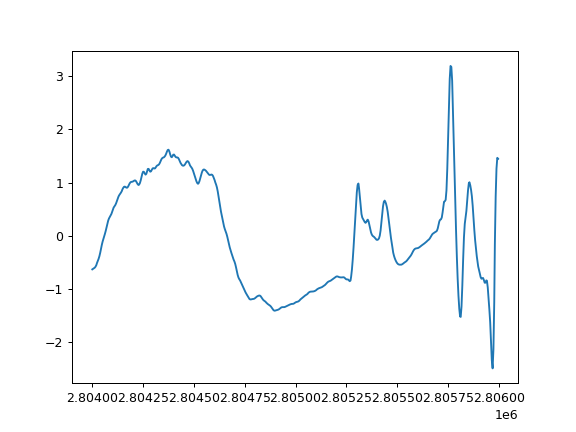

In [46]:
loader = DataLoader(
        dataset, batch_size=10, shuffle=True, num_workers=num_workers)
for idx_batch, (batch_x, batch_y, batch_t) in enumerate(loader):
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_x = torch.squeeze(batch_x,1)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    batch_t = batch_t.to(device=device, dtype=torch.float32)
    break
plt.plot(batch_t[0],batch_x[0][0])
plt.show()

In [37]:
# TRAIN AND MONITOR NETWORK
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
sfreq = 256.0  # Sampling frequency
n_channels = 4
print(sfreq, n_channels)
# Create dataloaders
train_batch_size = 180 #180  #45
valid_batch_size = 180 #180  #45
num_workers = 0
torch.manual_seed(87)
np.random.seed(87)

256.0 4


In [ ]:
model = IEEGSeizureDetection_2sec(n_channels, sfreq, n_classes=2)
print(f'Using device \'{device}\'.')
model = model.to(device)
print(model.summary)

In [ ]:
from torchvision import models
from torchsummary import summary

vgg = models.vgg16()
summary(vgg, (3, 224, 224))

LeaveOneOut Cross Validation 1
Check values for train and test [1 2 3 4] [0]
Training: 7200  Validation: 1800
Check parameters 128 8 1280 64 4 1200
Using device 'cpu'.
epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf 	 valid_ap 	 valid_f1
-------------------------------------------------------------------
Check number of epochs to run for LOOCV folds after selecting best hyperparam 10
1 	 0.6327 	 0.5431 	 0.4889 	 0.5000	 0.0050	 0.0000
2 	 0.5138 	 0.4595 	 0.5000 	 0.5000	 0.0050	 0.0000
3 	 0.4438 	 0.3915 	 0.5000 	 0.5000	 0.0050	 0.0000
4 	 0.3879 	 0.3360 	 0.5000 	 0.5000	 0.0050	 0.0000
5 	 0.3432 	 0.2915 	 0.5000 	 0.5000	 0.0050	 0.0000
6 	 0.3075 	 0.2552 	 0.5000 	 0.5000	 0.0050	 0.0000
7 	 0.2791 	 0.2255 	 0.5000 	 0.5000	 0.0050	 0.0000
8 	 0.2562 	 0.2014 	 0.5000 	 0.5000	 0.0050	 0.0000
9 	 0.2378 	 0.1812 	 0.5000 	 0.5000	 0.0050	 0.0000
10 	 0.2228 	 0.1644 	 0.5000 	 0.5000	 0.0050	 0.0000


<IPython.core.display.Javascript object>


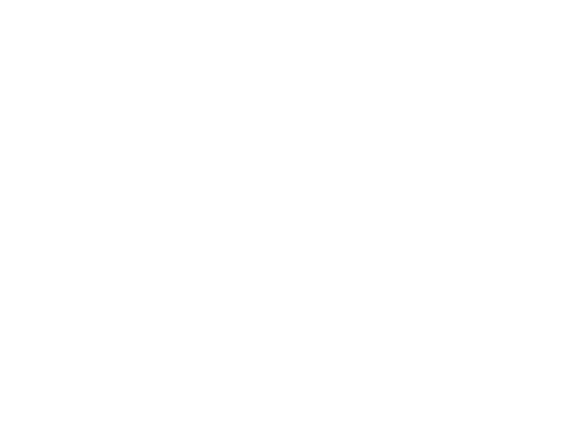

Check parameters 128 8 1280 64 4 1200
Check dimensions (1800,) (1800,)


<IPython.core.display.Javascript object>


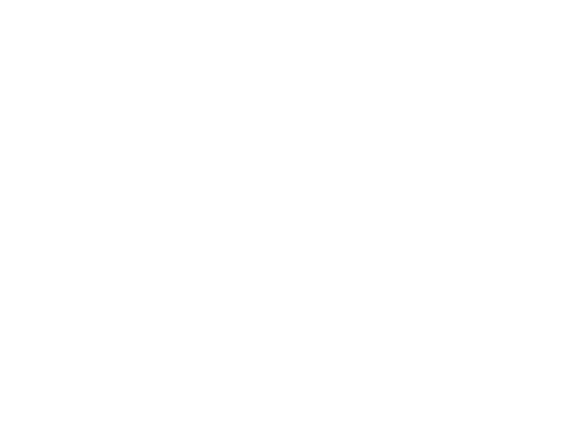

Best Threshold=0.144050, F-Score=0.010
Best Precision=0.005, Best Recall=1.000
bestF1=0.010000
Average Precision=0.005000
Plotting ROC


<IPython.core.display.Javascript object>


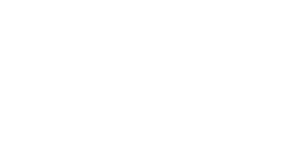

AUPRC=0.502500, AUROC=0.500000


<IPython.core.display.Javascript object>


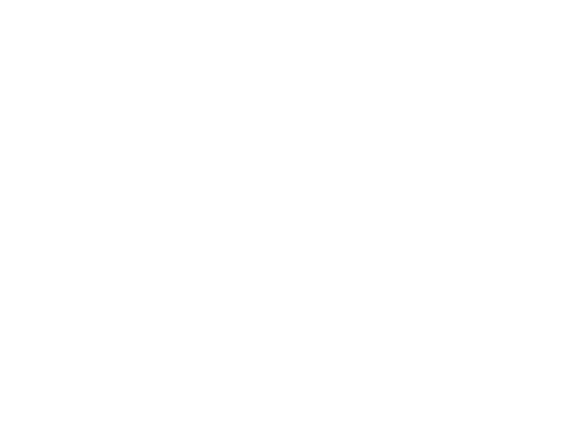

<IPython.core.display.Javascript object>


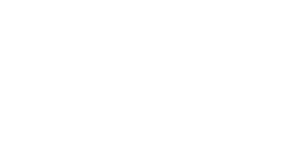

Test balanced accuracy: 0.500
Test Cohen's kappa: 0.000
conf_mat [[   0 1791]
 [   0    9]]


<IPython.core.display.Javascript object>


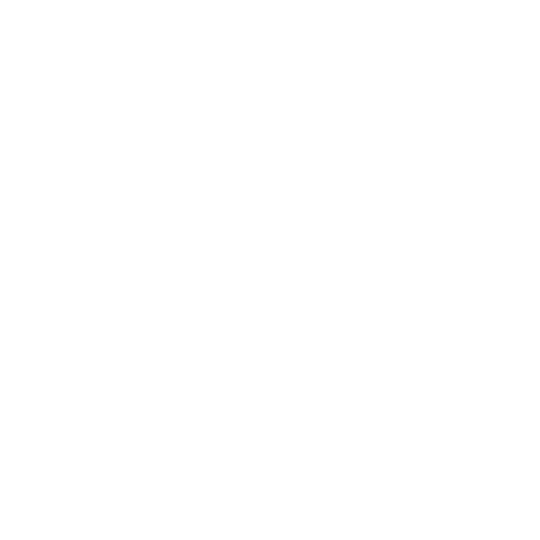

Indices (array([     0,      1,      2, ..., 921597, 921598, 921599]),) (array([542208, 542209, 542210, ..., 546813, 546814, 546815]),) 921600
Exiting for loop....
pred correct 542208
Indices 0 542208 542208
STATUS : False detection happened, but there is a seizure also
Prediction time 2118000.0 True time 2118000.0
STATUS : Detection delay of 0.0 secs


<IPython.core.display.Javascript object>


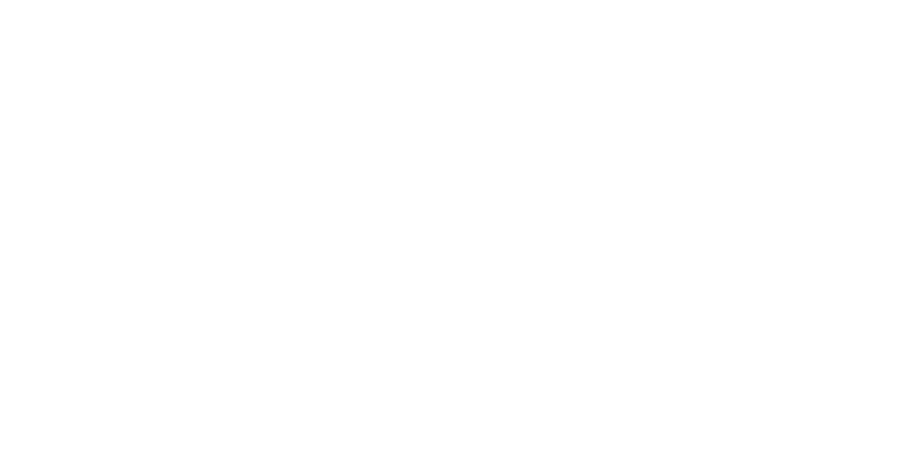

Best f1 score 0.01 Calculated f1 score 0.01
f1_score_eval: 0.010 	  average_precision: 0.005 	auc_precision_recall: 0.502 	  detection_delay: 0.000  	false_positive: 1791.000 	 false_negativ: 0.000
Test balanced accuracy: 0.500
Test Cohen's kappa: 0.000
conf_mat [[1791    0]
 [   9    0]]


<IPython.core.display.Javascript object>


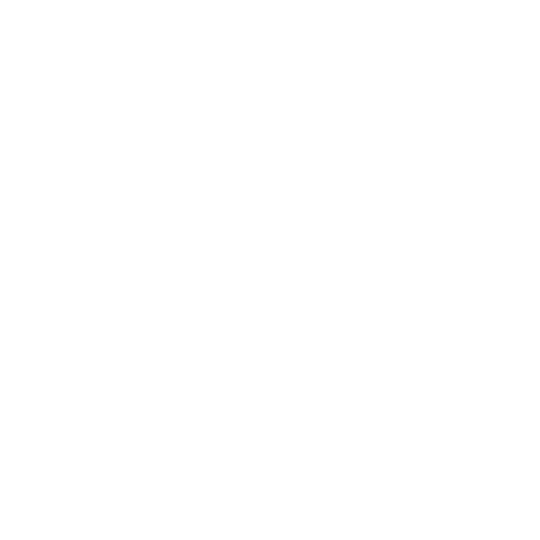

STATUS : Detection Missed


<IPython.core.display.Javascript object>


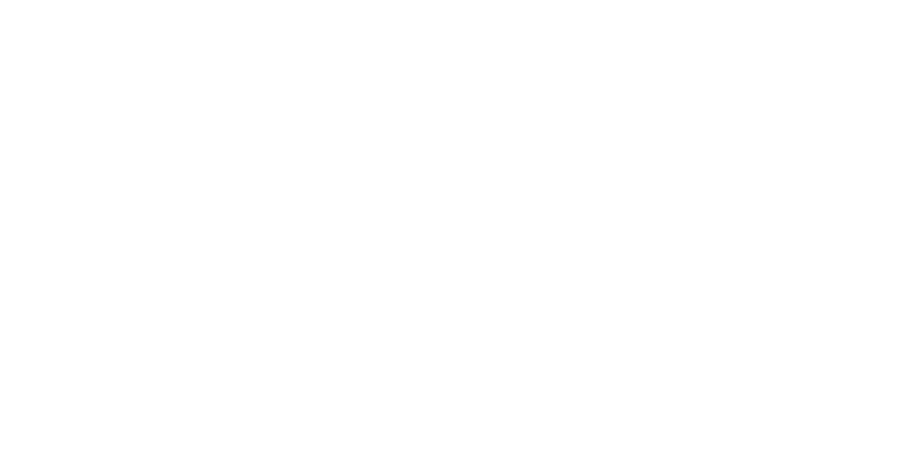

Best f1 score 0.01 Calculated f1 score 0.0
f1_score_eval: 0.000 	  average_precision: 0.005 	auc_precision_recall: 0.502 	  detection_delay: 1000.000  	false_positive: 0.000 	 false_negativ: 9.000
LeaveOneOut Cross Validation 2
Check values for train and test [0 2 3 4] [1]
Training: 7200  Validation: 1800
Check parameters 128 8 1280 64 4 1200
Using device 'cpu'.
epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf 	 valid_ap 	 valid_f1
-------------------------------------------------------------------
Check number of epochs to run for LOOCV folds after selecting best hyperparam 10
1 	 0.4348 	 0.2068 	 0.4997 	 0.5000	 0.3071	 0.0000
2 	 0.0792 	 0.1948 	 0.5000 	 0.5000	 0.6838	 0.0000
3 	 0.0509 	 0.1598 	 0.5000 	 0.5000	 0.7066	 0.0000
4 	 0.0407 	 0.1885 	 0.5000 	 0.5000	 0.6917	 0.0000
5 	 0.0374 	 0.1606 	 0.5000 	 0.5000	 0.7180	 0.0000
6 	 0.0302 	 0.1587 	 0.7350 	 0.7233	 0.7206	 0.6174
7 	 0.0306 	 0.1569 	 0.8211 	 0.7961	 0.7091	 0.7439
8 	 0.0245 	 0.1765 	 0.8641

<IPython.core.display.Javascript object>


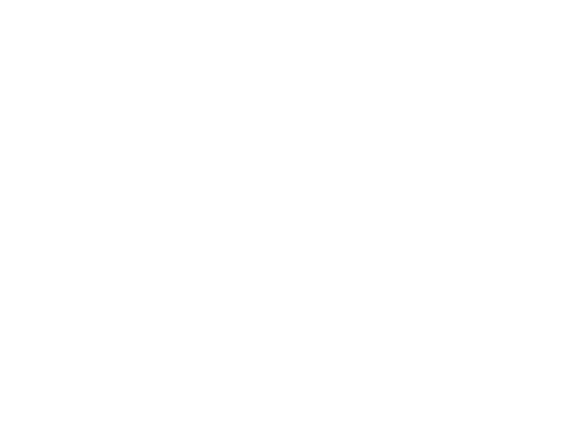

Check parameters 128 8 1280 64 4 1200
Check dimensions (1800,) (1800,)


<IPython.core.display.Javascript object>


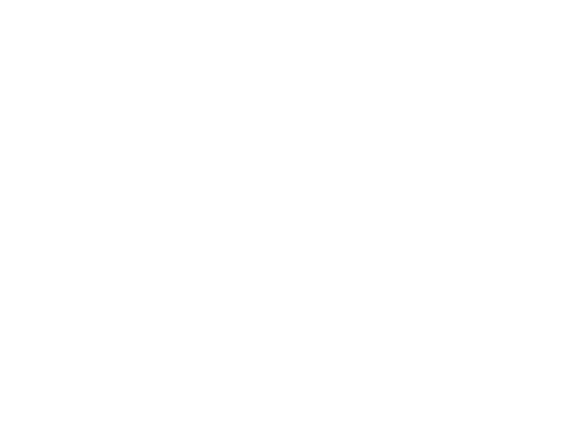

Best Threshold=0.098180, F-Score=0.739
Best Precision=0.890, Best Recall=0.631
bestF1=0.738600
Average Precision=0.690100
Plotting ROC


<IPython.core.display.Javascript object>


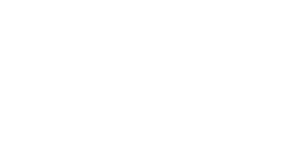

AUPRC=0.690100, AUROC=0.822800


<IPython.core.display.Javascript object>


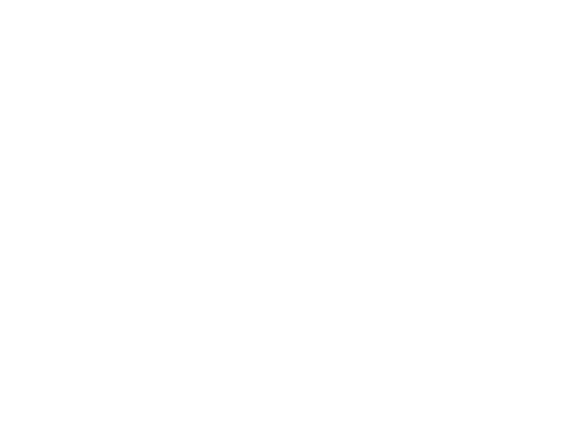

<IPython.core.display.Javascript object>


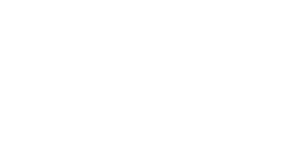

Test balanced accuracy: 0.808
Test Cohen's kappa: 0.718
conf_mat [[1689    8]
 [  39   64]]


<IPython.core.display.Javascript object>


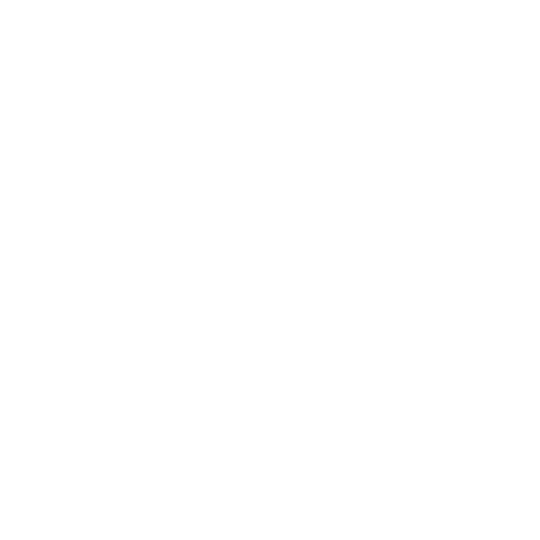

Indices (array([ 17920,  17921,  17922, ..., 889341, 889342, 889343]),) (array([132096, 132097, 132098, ..., 184829, 184830, 184831]),) 36864
Exiting for loop....
pred correct 132608
Indices 17920 132096 132608
STATUS : False detection happened, but there is a seizure also
Prediction time 518000.0 True time 516000.0
STATUS : Detection delay of 2.0 secs


<IPython.core.display.Javascript object>


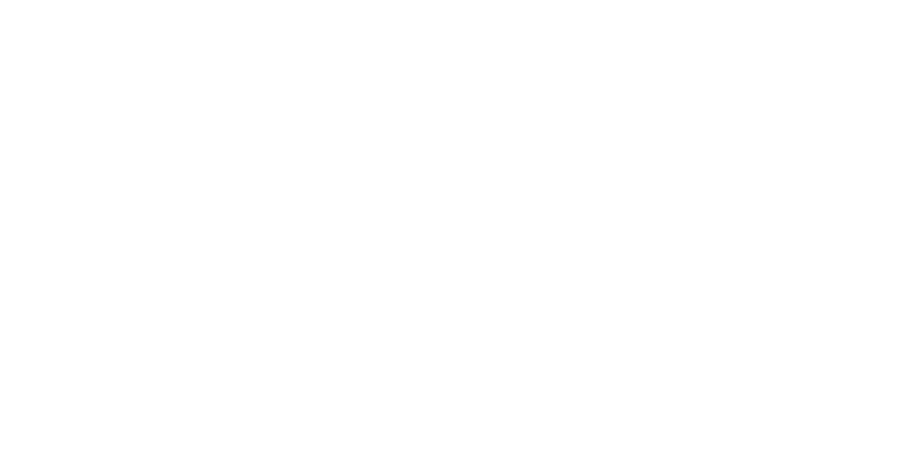

Best f1 score 0.7386 Calculated f1 score 0.7314
f1_score_eval: 0.731 	  average_precision: 0.690 	auc_precision_recall: 0.690 	  detection_delay: 2.000  	false_positive: 8.000 	 false_negativ: 39.000
Test balanced accuracy: 0.762
Test Cohen's kappa: 0.675
conf_mat [[1697    0]
 [  49   54]]


<IPython.core.display.Javascript object>


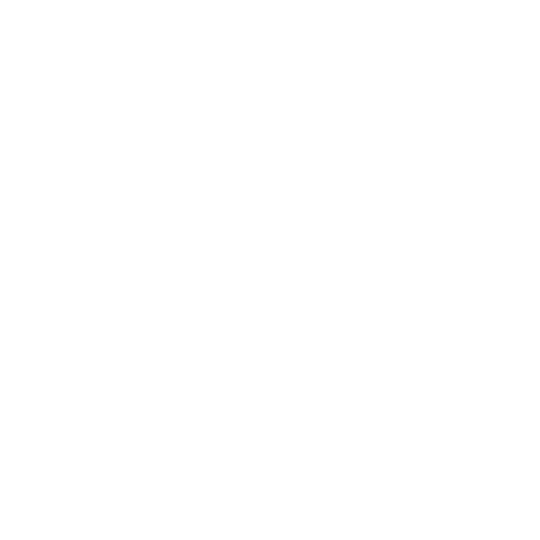

Indices (array([133120, 133121, 133122, ..., 170493, 170494, 170495]),) (array([132096, 132097, 132098, ..., 184829, 184830, 184831]),) 27648
pred correct 133120
Indices 133120 132096 133120
Prediction time 520000.0 True time 516000.0
STATUS : Detection delay of 4.0 secs


<IPython.core.display.Javascript object>


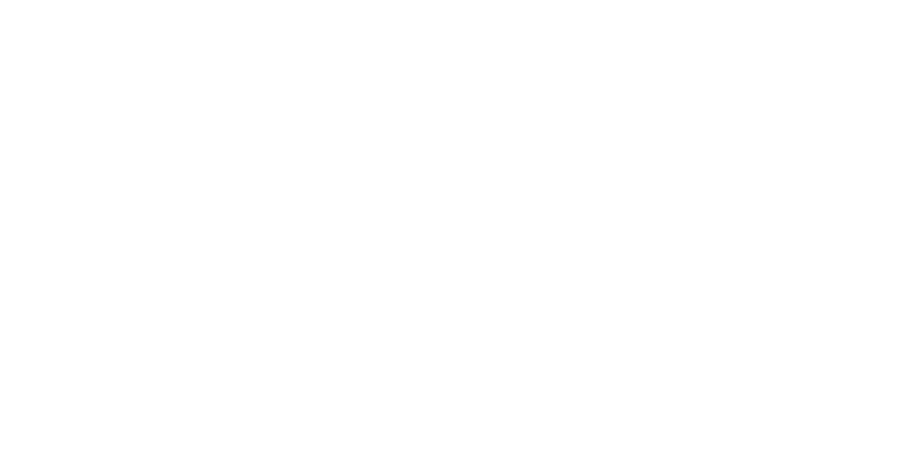

Best f1 score 0.7386 Calculated f1 score 0.6879
f1_score_eval: 0.688 	  average_precision: 0.690 	auc_precision_recall: 0.690 	  detection_delay: 4.000  	false_positive: 0.000 	 false_negativ: 49.000
LeaveOneOut Cross Validation 3
Check values for train and test [0 1 3 4] [2]
Training: 7200  Validation: 1800
Check parameters 128 8 1280 64 4 1200
Using device 'cpu'.
epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf 	 valid_ap 	 valid_f1
-------------------------------------------------------------------
Check number of epochs to run for LOOCV folds after selecting best hyperparam 10
1 	 0.3016 	 0.1232 	 0.4971 	 0.5000	 0.5204	 0.0000
2 	 0.0900 	 0.0888 	 0.5000 	 0.5000	 0.7892	 0.0000
3 	 0.0742 	 0.0686 	 0.5000 	 0.5000	 0.8979	 0.0000
4 	 0.0701 	 0.0671 	 0.5000 	 0.5000	 0.9245	 0.0000
5 	 0.0639 	 0.0630 	 0.5000 	 0.5000	 0.9172	 0.0000
6 	 0.0598 	 0.0557 	 0.5000 	 0.5000	 0.9317	 0.0000
7 	 0.0615 	 0.0579 	 0.5000 	 0.5000	 0.9227	 0.0000
8 	 0.0557 	 0.0506 	 0.5

<IPython.core.display.Javascript object>


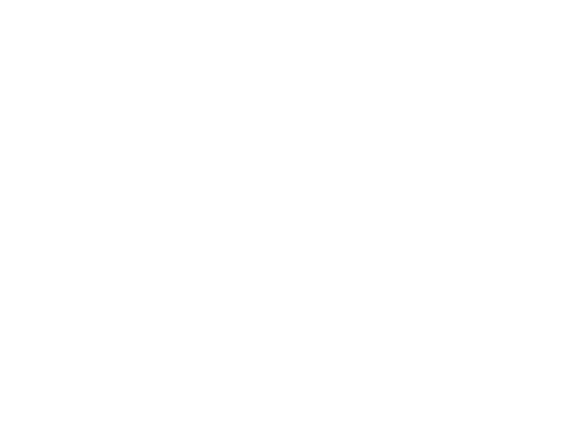

Check parameters 128 8 1280 64 4 1200
Check dimensions (1800,) (1800,)


<IPython.core.display.Javascript object>


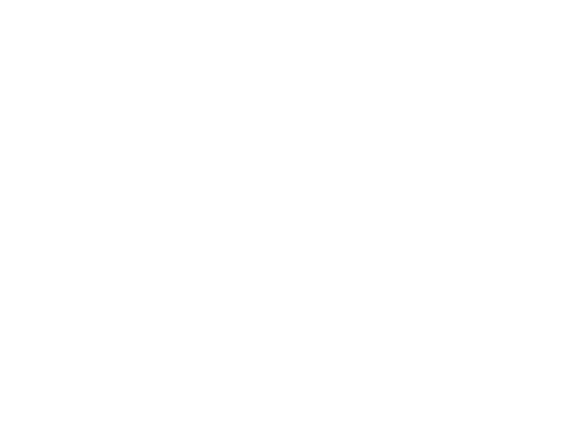

Best Threshold=0.309240, F-Score=0.898
Best Precision=0.964, Best Recall=0.841
bestF1=0.898300
Average Precision=0.940700
Plotting ROC


<IPython.core.display.Javascript object>


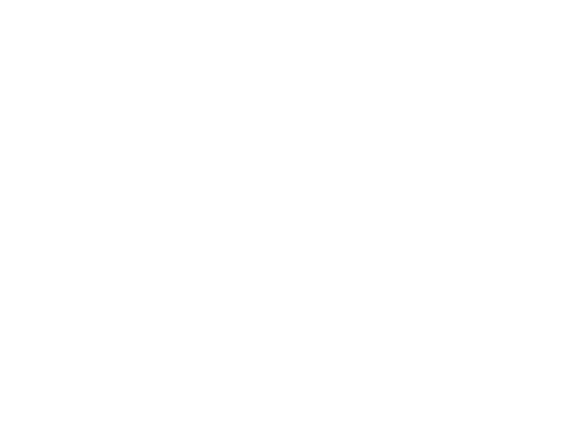

AUPRC=0.940500, AUROC=0.987000


<IPython.core.display.Javascript object>


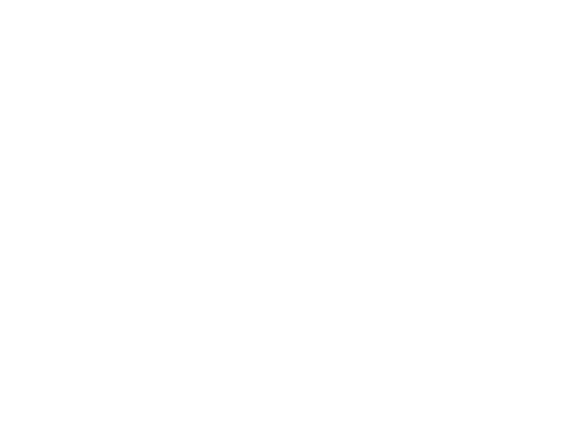

<IPython.core.display.Javascript object>


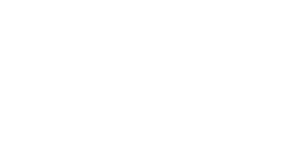

Test balanced accuracy: 0.920
Test Cohen's kappa: 0.895
conf_mat [[1735    2]
 [  10   53]]


<IPython.core.display.Javascript object>


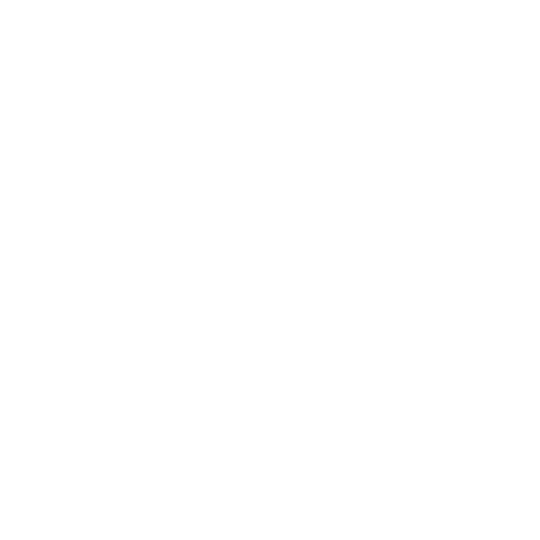

Indices (array([ 14336,  14337,  14338, ..., 862205, 862206, 862207]),) (array([105472, 105473, 105474, ..., 137725, 137726, 137727]),) 28160
Exiting for loop....
pred correct 106496
Indices 14336 105472 106496
STATUS : False detection happened, but there is a seizure also
Prediction time 416000.0 True time 412000.0
STATUS : Detection delay of 4.0 secs


<IPython.core.display.Javascript object>


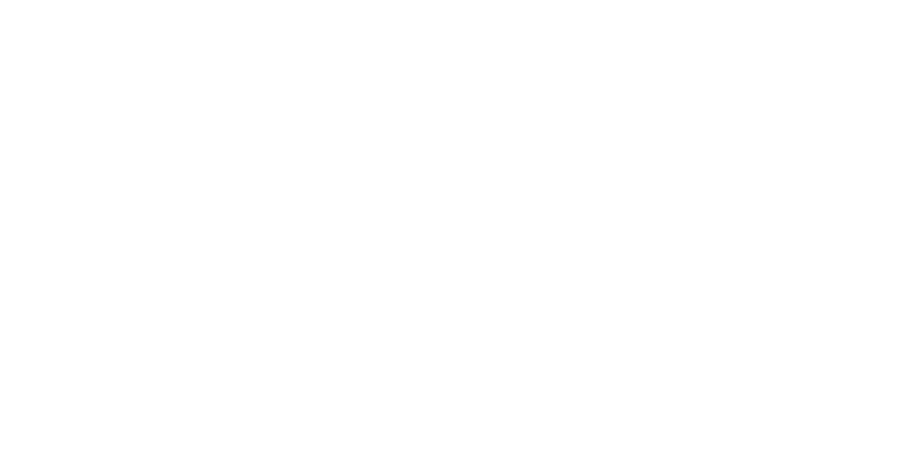

Best f1 score 0.8983 Calculated f1 score 0.8983
f1_score_eval: 0.898 	  average_precision: 0.941 	auc_precision_recall: 0.941 	  detection_delay: 4.000  	false_positive: 2.000 	 false_negativ: 10.000
Test balanced accuracy: 0.881
Test Cohen's kappa: 0.853
conf_mat [[1736    1]
 [  15   48]]


<IPython.core.display.Javascript object>


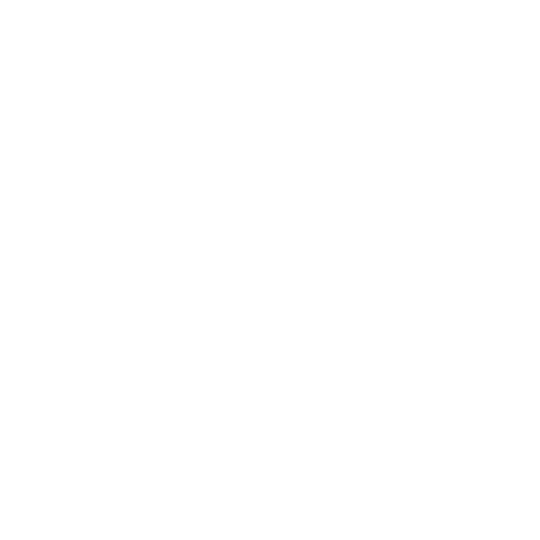

Indices (array([ 14336,  14337,  14338, ..., 137213, 137214, 137215]),) (array([105472, 105473, 105474, ..., 137725, 137726, 137727]),) 25088
Exiting for loop....
pred correct 106496
Indices 14336 105472 106496
STATUS : False detection happened, but there is a seizure also
Prediction time 416000.0 True time 412000.0
STATUS : Detection delay of 4.0 secs


<IPython.core.display.Javascript object>


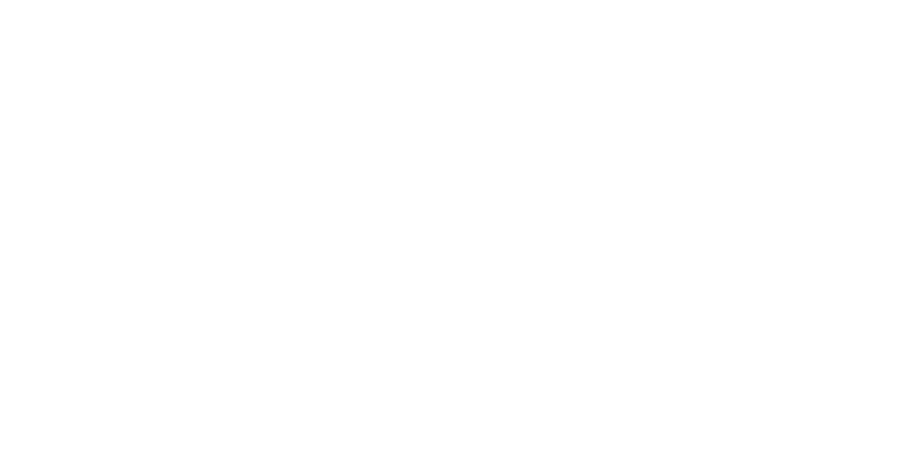

Best f1 score 0.8983 Calculated f1 score 0.8571
f1_score_eval: 0.857 	  average_precision: 0.941 	auc_precision_recall: 0.941 	  detection_delay: 4.000  	false_positive: 1.000 	 false_negativ: 15.000
LeaveOneOut Cross Validation 4
Check values for train and test [0 1 2 4] [3]
Training: 7200  Validation: 1800
Check parameters 128 8 1280 64 4 1200
Using device 'cpu'.
epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf 	 valid_ap 	 valid_f1
-------------------------------------------------------------------
Check number of epochs to run for LOOCV folds after selecting best hyperparam 10
1 	 0.3548 	 0.2171 	 0.5000 	 0.5000	 0.4585	 0.0000
2 	 0.1177 	 0.0827 	 0.5000 	 0.5000	 0.8750	 0.0000
3 	 0.0863 	 0.1150 	 0.5000 	 0.5000	 0.7917	 0.0000
4 	 0.0831 	 0.1348 	 0.5000 	 0.5000	 0.7834	 0.0000
5 	 0.0771 	 0.0729 	 0.5000 	 0.5000	 0.8730	 0.0000
6 	 0.0672 	 0.0757 	 0.5125 	 0.8608	 0.8956	 0.8298
7 	 0.0534 	 0.1682 	 0.7874 	 0.9199	 0.8498	 0.4434
8 	 0.0505 	 0.0368 	 0.8

<IPython.core.display.Javascript object>


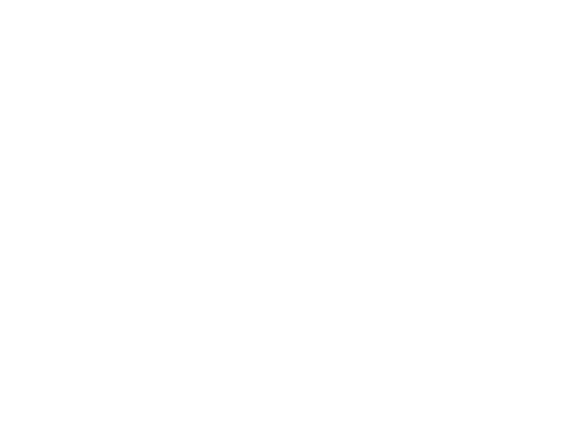

Check parameters 128 8 1280 64 4 1200
Check dimensions (1800,) (1800,)


<IPython.core.display.Javascript object>


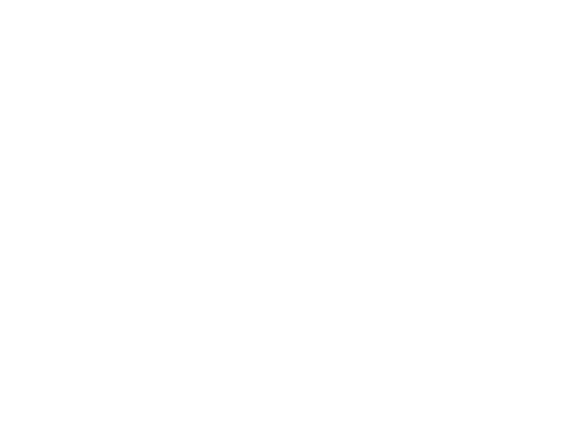

Best Threshold=0.953050, F-Score=0.874
Best Precision=0.918, Best Recall=0.833
bestF1=0.873800
Average Precision=0.924200
Plotting ROC


<IPython.core.display.Javascript object>


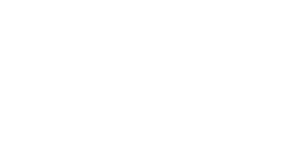

AUPRC=0.923800, AUROC=0.988800


<IPython.core.display.Javascript object>


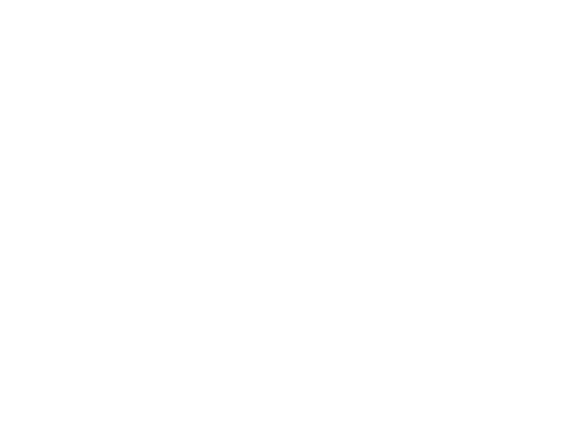

<IPython.core.display.Javascript object>


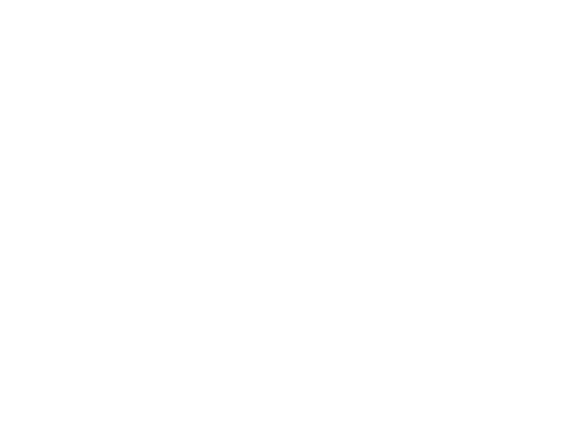

Test balanced accuracy: 0.915
Test Cohen's kappa: 0.870
conf_mat [[1742    4]
 [   9   45]]


<IPython.core.display.Javascript object>


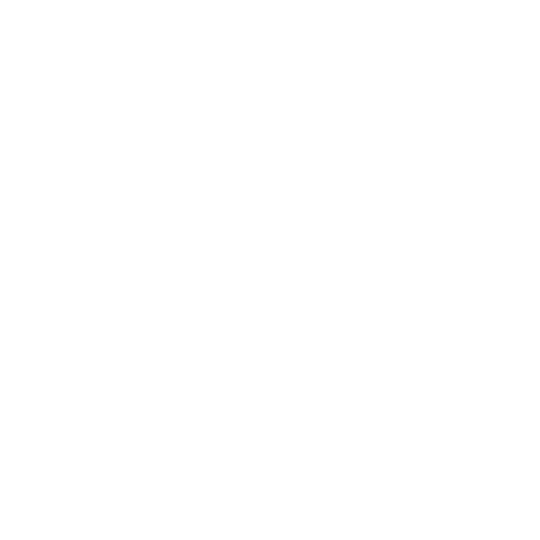

Indices (array([211456, 211457, 211458, ..., 834557, 834558, 834559]),) (array([217088, 217089, 217090, ..., 244733, 244734, 244735]),) 25088
Exiting for loop....
pred correct 217600
Indices 211456 217088 217600
STATUS : False detection happened, but there is a seizure also
Prediction time 850000.0 True time 848000.0
STATUS : Detection delay of 2.0 secs


<IPython.core.display.Javascript object>


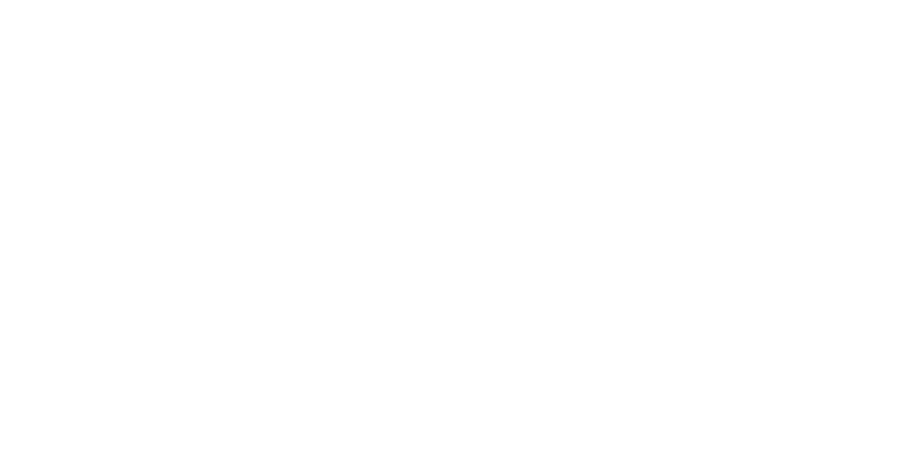

Best f1 score 0.8738 Calculated f1 score 0.8738
f1_score_eval: 0.874 	  average_precision: 0.924 	auc_precision_recall: 0.924 	  detection_delay: 2.000  	false_positive: 4.000 	 false_negativ: 9.000
Test balanced accuracy: 0.957
Test Cohen's kappa: 0.631
conf_mat [[1693   53]
 [   3   51]]


<IPython.core.display.Javascript object>


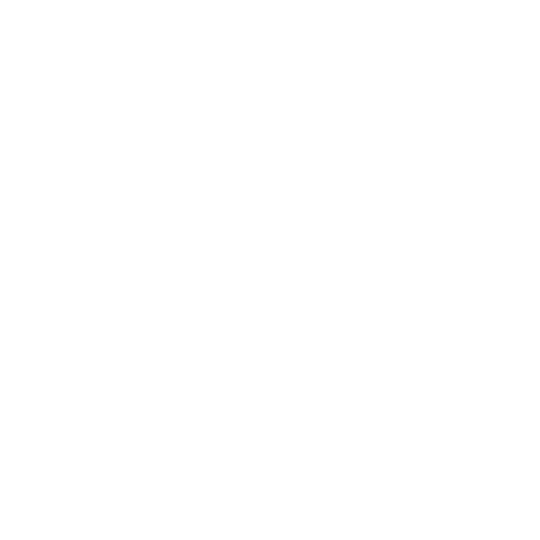

Indices (array([ 22016,  22017,  22018, ..., 919549, 919550, 919551]),) (array([217088, 217089, 217090, ..., 244733, 244734, 244735]),) 53248
Exiting for loop....
pred correct 217600
Indices 22016 217088 217600
STATUS : False detection happened, but there is a seizure also
Prediction time 850000.0 True time 848000.0
STATUS : Detection delay of 2.0 secs


<IPython.core.display.Javascript object>


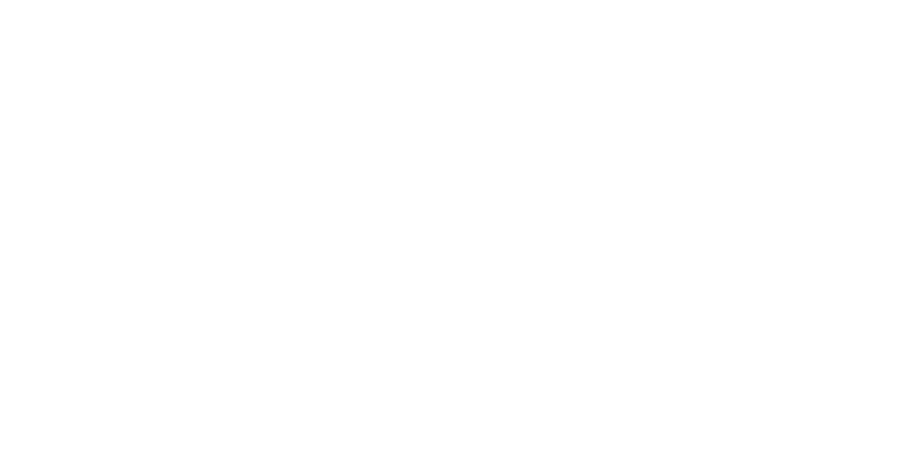

Best f1 score 0.8738 Calculated f1 score 0.6456
f1_score_eval: 0.646 	  average_precision: 0.924 	auc_precision_recall: 0.924 	  detection_delay: 2.000  	false_positive: 53.000 	 false_negativ: 3.000
LeaveOneOut Cross Validation 5
Check values for train and test [0 1 2 3] [4]
Training: 7200  Validation: 1800
Check parameters 128 8 1280 64 4 1200
Using device 'cpu'.
epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf 	 valid_ap 	 valid_f1
-------------------------------------------------------------------
Check number of epochs to run for LOOCV folds after selecting best hyperparam 10
1 	 0.2682 	 0.0935 	 0.5000 	 0.5000	 0.0089	 0.0000
2 	 0.0838 	 0.1056 	 0.5000 	 0.5000	 0.0120	 0.0000
3 	 0.0785 	 0.0959 	 0.5000 	 0.5000	 0.0105	 0.0000
4 	 0.0693 	 0.0840 	 0.5000 	 0.5000	 0.0248	 0.0000
5 	 0.0660 	 0.0792 	 0.5000 	 0.5000	 0.0259	 0.0000
6 	 0.0612 	 0.1096 	 0.5000 	 0.5000	 0.0095	 0.0000
7 	 0.0593 	 0.0941 	 0.5000 	 0.5000	 0.0149	 0.0000
8 	 0.0589 	 0.0744 	 0.5

<IPython.core.display.Javascript object>


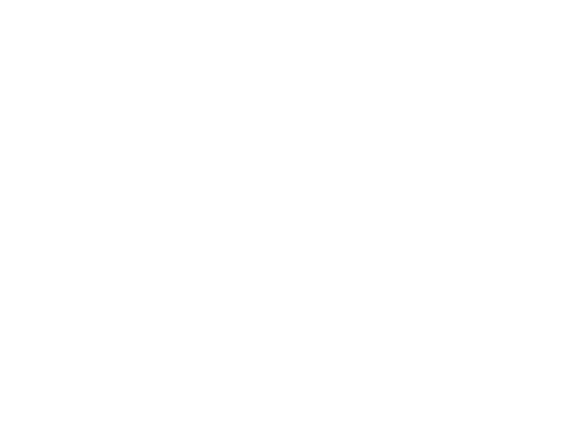

Check parameters 128 8 1280 64 4 1200
Check dimensions (1800,) (1800,)


<IPython.core.display.Javascript object>


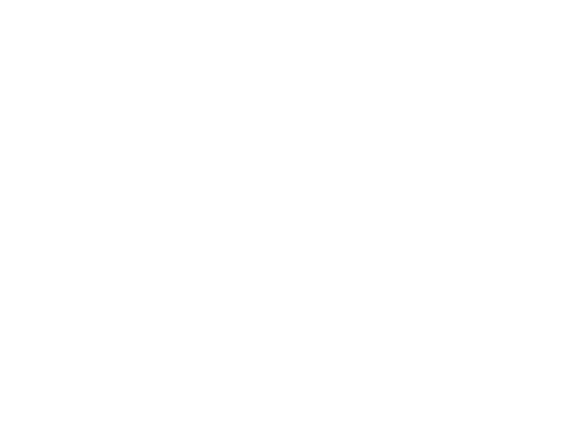

Best Threshold=0.050200, F-Score=nan
Best Precision=0.000, Best Recall=0.000
bestF1=nan
Average Precision=0.027600
Plotting ROC


<IPython.core.display.Javascript object>


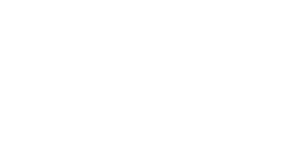

AUPRC=0.024300, AUROC=0.617300


<IPython.core.display.Javascript object>


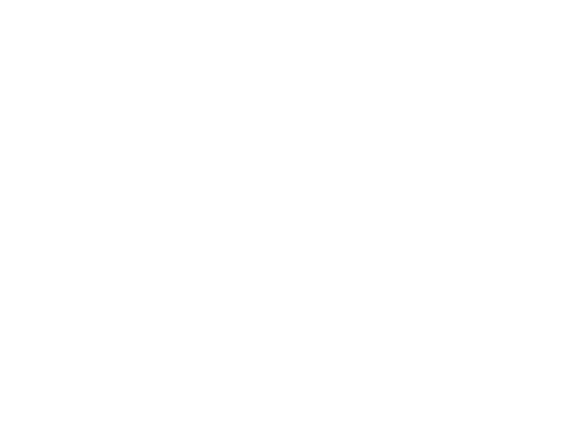

<IPython.core.display.Javascript object>


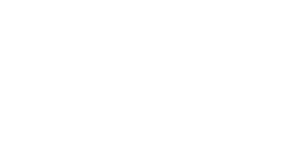

Test balanced accuracy: 0.495
Test Cohen's kappa: -0.012
conf_mat [[1756   19]
 [  25    0]]


<IPython.core.display.Javascript object>


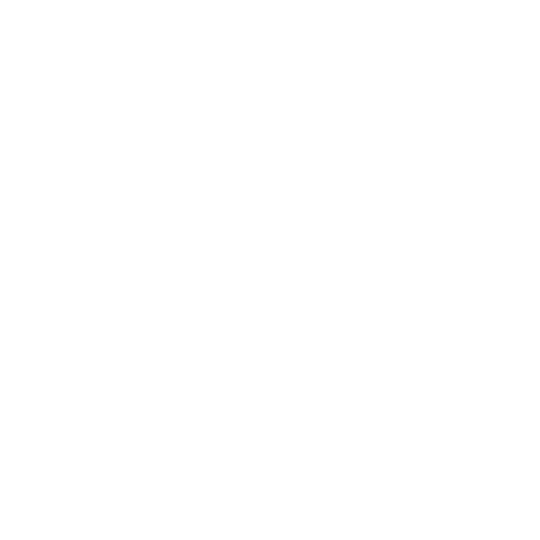

Indices (array([ 75264,  75265,  75266, ..., 801789, 801790, 801791]),) (array([279040, 279041, 279042, ..., 291837, 291838, 291839]),) 9728
Exiting for loop....
pred correct 310784
Indices 75264 279040 310784
STATUS : False detection happened, but there is a seizure also
Prediction time 1214000.0 True time 1090000.0
STATUS : Detection delay of 124.0 secs


<IPython.core.display.Javascript object>


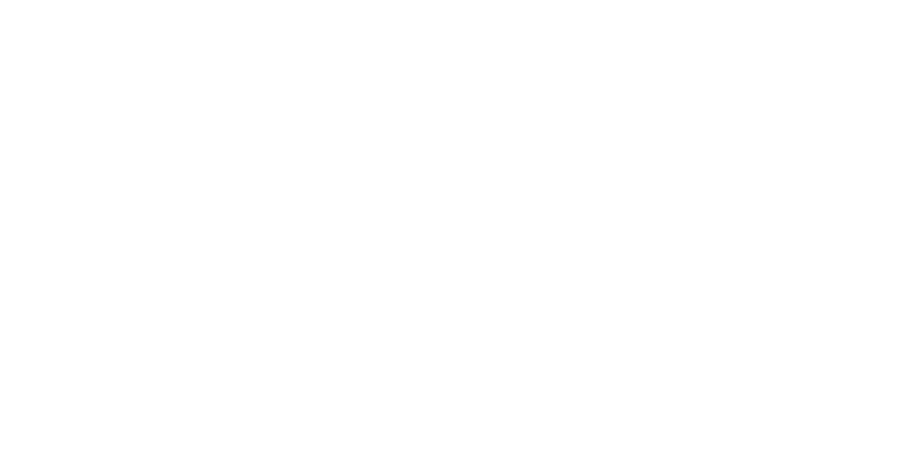

Best f1 score nan Calculated f1 score 0.0
f1_score_eval: 0.000 	  average_precision: 0.028 	auc_precision_recall: 0.024 	  detection_delay: 124.000  	false_positive: 19.000 	 false_negativ: 25.000
Test balanced accuracy: 0.500
Test Cohen's kappa: 0.000
conf_mat [[1775    0]
 [  25    0]]


<IPython.core.display.Javascript object>


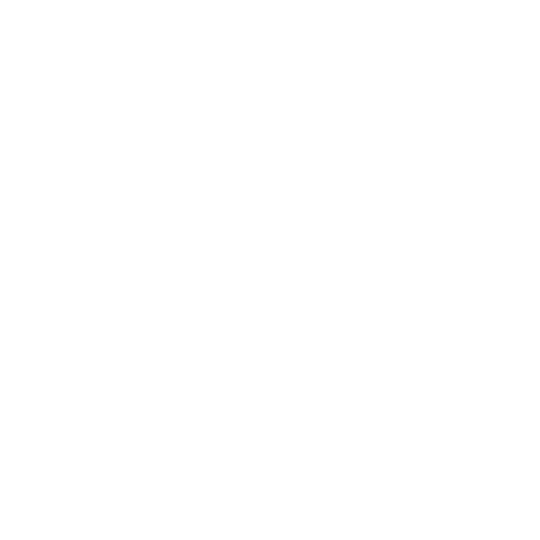

STATUS : Detection Missed


<IPython.core.display.Javascript object>


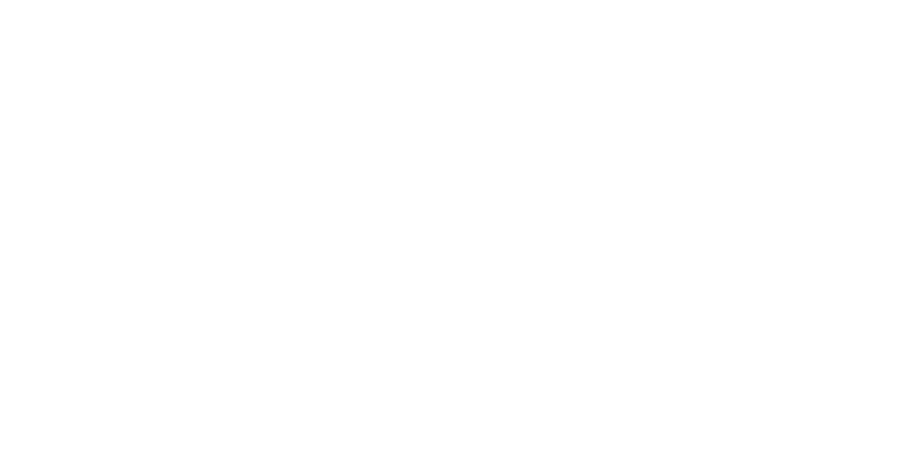

Best f1 score nan Calculated f1 score 0.0
f1_score_eval: 0.000 	  average_precision: 0.028 	auc_precision_recall: 0.024 	  detection_delay: 1000.000  	false_positive: 0.000 	 false_negativ: 25.000


In [20]:
from sklearn.model_selection import LeaveOneOut
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.metrics import balanced_accuracy_score
import warnings
warnings.filterwarnings('ignore')

n_epochs = 10 #200
patience = 50   #40    #25

loss_list = []
ap_list = []
auprc_list = []
auroc_list = []
best_th = []

b_perf_list = []
b_f1_list = []
b_fp_list = []
b_dd_list = []
b_fn_list = []
b_tp_list = []
b_tn_list = []

o_perf_list = []
o_f1_list = []
o_fp_list = []
o_dd_list = []
o_fn_list = []
o_tp_list = []
o_tn_list = []

for fold, (train_idx,valid_idx) in enumerate(LeaveOneOut().split(np.arange(len(dataset.datasets)))):
    print('LeaveOneOut Cross Validation {}'.format(fold + 1))
    print('Check values for train and test', train_idx, valid_idx)
    
    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in valid_idx])
    print(f'Training: {len(train_ds)}  Validation: {len(test_ds)}')
    
    loader_train = DataLoader(
        train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
    loader_test = DataLoader(
        test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
    loader_test_1epoch = DataLoader(
        test_ds, batch_size=test_ds.__len__(), shuffle=False, num_workers=num_workers)
    
    classes_mapping = {0: 'non-ictal', 1: 'ictal'}
    train_y = pd.Series([y for _, y,_ in train_ds]).map(classes_mapping)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
    
    model = IEEGSeizureDetection_2sec(n_channels, sfreq, n_classes=2)
    print(f'Using device \'{device}\'.')
    model = model.to(device)
    model.apply(reset_weights)
    
    optimizer = Adam(model.parameters(), lr=3e-3, weight_decay=0)   #use 3,3 for 2D CNN, 1,4 for 1D CNN0.01795
    #optimizer = Adam(model.parameters(), lr=0.01795, weight_decay=0)
    #optimizer = Adam(model.parameters(), lr=0.0215, weight_decay=0)
    #criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device)) 
    criterion = CrossEntropyLoss() 
    #criterion = BCEWithLogitsLoss()
    
    
    history = train(
    model, loader_train, loader_test , optimizer, criterion, n_epochs, fold,patience, 
    device, metric=balanced_accuracy_score)
    
    #Plot learning curve
    plot_learning_curve(history,str([patient_id[p_id]][0]),str(fold))
    
    #Load the best model saved in train()
    model_validate_1epoch = IEEGSeizureDetection_2sec(n_channels, sfreq, n_classes=2).to(device)
    model_validate_1epoch.load_state_dict(torch.load('./results_1D_softmax/temp/best-model-' + str([patient_id[p_id]][0]) +'_' +str(fold) +'.pth', map_location=device))
    
    #model = model.to(device)
    v_loss,v_ap,auprc,auroc,b_v_acc,b_v_f1,b_v_cm,b_v_dd,o_v_acc,o_v_f1,o_v_cm,o_v_dd, b_th = _validate_1epoch(
         model_validate_1epoch, loader_test_1epoch, criterion, fold,device, metric=balanced_accuracy_score)
    
    loss_list.append(v_loss)
    ap_list.append(v_ap)
    auprc_list.append(auprc)
    auroc_list.append(auroc)
    
    b_perf_list.append(b_v_acc)
    b_f1_list.append(b_v_f1)           
    b_tn_list.append(b_v_cm[0][0])
    b_fp_list.append(b_v_cm[0][1])
    b_fn_list.append(b_v_cm[1][0])
    b_tp_list.append(b_v_cm[1][1])
    b_dd_list.append(b_v_dd)

    o_perf_list.append(o_v_acc)
    o_f1_list.append(o_v_f1)           
    o_tn_list.append(o_v_cm[0][0])
    o_fp_list.append(o_v_cm[0][1])
    o_fn_list.append(o_v_cm[1][0])
    o_tp_list.append(o_v_cm[1][1])
    o_dd_list.append(o_v_dd)
    
    best_th.append(b_th)
    #break
#print('Lists:',loss_list, perf_list, ap_list, f1_list, dd_list,tn_list,fp_list,fn_list,tp_list,auprc_list,auroc_list)

#Add other stuff AUPRC, AUROC

In [ ]:
#Write final values to csv
from itertools import zip_longest
all_metric_best = [ap_list,auprc_list,auroc_list,b_perf_list,b_f1_list,b_tn_list,b_fp_list,b_fn_list,b_tp_list,b_dd_list, best_th]
all_metric_opt = [ap_list,auprc_list,auroc_list,o_perf_list,o_f1_list,o_tn_list,o_fp_list,o_fn_list,o_tp_list,o_dd_list]

export_data_best = zip_longest(*all_metric_best, fillvalue = '')
with open('./results_1D_softmax/temp/eval-results-best-' + str([patient_id[p_id]][0]) +'.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(("AP","AUPRC","AUROC", "Accuracy","F1","TN","FP", "FN","TP","Detection Delay","Chosen Threshold"))
    wr.writerows(export_data_best)
myfile.close()

export_data_opt = zip_longest(*all_metric_opt, fillvalue = '')
with open('./results_1D_softmax/temp/eval-results-opt-' + str([patient_id[p_id]][0]) +'.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(("AP","AUPRC","AUROC","Accuracy", "F1","TN","FP", "FN","TP","Detection Delay"))
    wr.writerows(export_data_opt)
myfile.close()